# Regresor para estimar el espaciamiento espectral

- [x] Agregar la métrica de RMSE.
- [x] Cambiar las gráficas para que se distingan por marcadores y solo con los puntos discretos.
- [x] Probar con los datos GKM.
- [x] Cambiar ReLu por Swish.
- [x] Graficar la función de pérdida.
- [x] Variar el número de capas ocultas (1 a 4 capas, (relu), (relu, sigmoid), (relu, tanh, sigmoid), (relu, relu, tanh, sigmoid).
- [x] Hacer una prueba con la función de pérdida MSE, (RMSE).
- [x] Recortar el historial de peŕdida (Apróximadamente en 500, para ver el cambio brusco)
- [x] $\mu$ (eje y) vs. hidden layers number (eje x), para todos los escenarios (B2B, 0dBm, 9dBm), 3 gráficas (una para cada métrica) 
- [x] Para la evaluación de la función de pérdida (MSE vs. MAE) cambiar el eje y para usar $\mu$ y el eje x, se separan los escenarios (poner 3 índices y luego cambiarles la apariencia).
- [ ] Evolucionar la red neuronal a un clasificador basado en los mejores parámetros y probar con diferente número de clases (de 2 a 5 clases, como Alejandro).
- [ ] Demodular usando redes neuronales (empezar con pocas neuronas y una sola capa oculta).

In [1]:
# Imports
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker

from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, f1_score, multilabel_confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from time import time

2023-05-06 14:19:28.907752: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-06 14:19:29.023269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 14:19:29.205843: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-06 14:19:29.207576: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 14:19:30.048261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Funciones globales

In [2]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

### Regresión

In [3]:
def estimation_model(input_dim, layers_props_lst, loss_fn):
    """ Compile a sequential model for regression purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Regressor
    model.add(ker.layers.Dense(units=1, activation="linear"))
    
    model.compile(loss=loss_fn, optimizer="adam")
    return model


def estimation_crossvalidation(X, y, n_splits, layer_props, loss_fn, callbacks):
    """ Crossvalidation of an estimation network. """
    # Store initial time
    t0 = time()

    # Scores dict
    scores = {}
    scores["loss"] = []
    scores["mae"] = {"train": [], "test": []}
    scores["r2"] = {"train": [], "test": []}
    scores["rmse"] = {"train": [], "test": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = estimation_model(X_train.shape[1], layer_props, loss_fn)
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Predict using train values
        predictions_train = model.predict(X_train)
        # Predict using test values
        predictions_test = model.predict(X_test_kf)

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # MAE
        mae_score_train = mean_absolute_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        mae_score_test = mean_absolute_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # R²
        r2_score_train = r2_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        r2_score_test = r2_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )
         
        # RMSE
        rmse_score_train = mean_squared_error(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            squared=False
        )
        rmse_score_test = mean_squared_error(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            squared=False
        )

        # Append to lists
        scores["loss"].append(loss)
        scores["mae"]["train"].append(mae_score_train)
        scores["mae"]["test"].append(mae_score_test)
        scores["r2"]["train"].append(r2_score_train)
        scores["r2"]["test"].append(r2_score_test)
        scores["rmse"]["train"].append(rmse_score_train)
        scores["rmse"]["test"].append(rmse_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_estimation_model(data, n_splits, max_neurons, activations, loss_fn="mean_absolute_error"):
    """ Test a spectral spacing estimation model with given parameters. """
    variables = 17

    # Split variables
    # Variables
    X = np.array(data[:, 0:variables]).T
    # Tags
    y = np.array(data[:, 19:20]).T
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=100, mode="min", restore_best_weights=True)
    ]
    
    return estimation_crossvalidation(X, y, n_splits, layer_props, loss_fn, callbacks)


def plot_loss(score, end=500):
    """ Plot loss evolution for each k-fold. """
    for k, loss in enumerate(score["loss"]):
        loss_length = len(loss.history["loss"])
        loss_values = loss.history["loss"][:end if loss_length > end else loss_length]
        epoch_values = range(end if loss_length > end else loss_length)
        plt.plot(epoch_values, loss_values, label=f"k = {k+1}")

def plot_losses(scores, scenario, cmp_fn, cmp_values=[], end=500, based_on_index=False):
    """ Plot loss graphics for each scenario. """
    # Handle default cmp_values
    if len(cmp_values) == 0:
        cmp_values = np.zeros(len(scores))
        
    fig_loss = plt.figure(figsize=(16, 3*len(scores)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    
    for index, (score, cmps) in enumerate(zip(scores, cmp_values)):
        plt.subplot(len(scores)//2, 2, index + 1)
        plot_loss(score, end=end)
        
        plt.title(cmp_fn(cmps) if not based_on_index else cmp_fn(index))
        
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        # Transparent white box black edge legend
        legend = plt.legend(loc="upper right", edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))
        
        plt.grid(True)

def plot_scores(scores, x_values, scenario, score_names, data_type, 
                markers, label, xlabel, based_on_index=False, log=False,
                multiple_points=False, plot_train=True):
    fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        ax = plt.subplot(1, len(score_names), i+1)
        for dt in data_type:
            if not plot_train and dt == "train":
                continue
            points = [np.average(score[sn][dt]) for score in scores]
            if not multiple_points:
                label_value = ""
                plt.scatter(x_values, points, marker=markers[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(i)}", s=100)
            else:
                label_value = ""
                points1 = points[::2]
                points2 = points[1::2]
                plt.scatter(x_values, points1, marker=markers[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(0)}", s=100)
                plt.scatter(x_values, points2, marker=markers[2 if dt == "train" else 3],
                            label=f"{dt.title()} {label(1)}", s=100)
            title = ""
            if sn == "r2":
                title = "R²"
            elif sn == "acc":
                title = "Accuracy"
            else:
                title = sn.upper()
            plt.title(title)
                
        plt.xlabel(xlabel)
        # Adjust logarithmic scale if requested
        if log:
            plt.xscale("log", base=2)
            
        # Make integer xticks if matches}
        if type(x_values[0]) == np.int64:
            ax.set_xticks(x_values)
            
        if type(x_values[0]) == str:
            ax.set_xticks(range(len(x_values)), x_values)
            
        # Adjust y limit to leave a space for legend box
        ylim = plt.ylim()
        plt.ylim(ylim[0], (ylim[1] + (ylim[1] - ylim[0])*0.25))

        # Transparent white box black edge legend
        legend = plt.legend(loc="upper right", edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))

        plt.grid(True)
        i += 1
    plt.show()    
        
def plot_neurons_scores(scores, max_neurons, scenario):
    score_names = ["mae", "r2", "rmse"]
    data_type = ["train", "test"] 
    markers = ["o", "v"]
    
    # Plot loss
    plot_losses(scores, scenario, lambda neurons: f"{neurons} max number of neurons", 
                max_neurons, end=500)
    plt.show()
    
    # Plot scores
    plot_scores(scores, max_neurons, scenario,
                score_names, data_type, markers, lambda _: "",
                "Maximum number of neurons", log=True)
    plt.show()

    
def plot_activations_scores(scores, scenario):
    pass
    # score_names = ["mae", "r2", "rmse"]
    # markers = ["^", "8", "*", "X"]
    # data_type = ["train", "test"]
    
    # # Graficar pérdida
    # plot_losses(scores, scenario,
    #             lambda index: f"{'FCM' if index%2 == 0 else 'GKM'} {'ReLu' if index<2 else 'Swish'}",
    #             end=500, based_on_index=True)
    # plt.show()
    
    # # Graficar puntajes
    # fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    # fig_scores.suptitle(f"{scenario} scores")
    # i = 0
    # for sn in score_names:
    #     plt.subplot(1, len(score_names), i+1)
    #     for dt in data_type:
    #         for j, (score, neurons) in enumerate(zip(scores, max_neurons)):
    #             points = score[sn][dt]

    #             k = np.arange(len(points), dtype = np.uint8) + 1
                 
    #             plt.scatter(k, points, marker=markers[j], 
    #                         label=f"{'FCM' if j%2 == 0 else 'GKM'} {'ReLu' if j<2 else 'Swish'}, µ = {np.mean(points):.3f}",
    #                         s = 100)
                
    #         plt.title(f"{'Train' if dt == 'train' else 'Test'}")
    #         plt.xlabel("k-fold")
    #         plt.xticks(k)
    #         plt.ylabel("MAE" if sn == "mae" else "R²" if sn == "r2" else "RMSE")
    #         ylim = plt.ylim()
    #         plt.ylim(ylim[0], (ylim[1] + (ylim[1] - ylim[0])*0.25))
    #         plt.grid(True)
    #         plt.legend(loc="upper right")
    #         i += 1
    # plt.show()
    
    
def plot_layers_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    data_type = ["train", "test"]
    markers = ["D", "H"]
    
    # Plot loss
    plot_losses(scores, scenario, lambda hl_n: f"{hl_n} hidden layers", range(1, len(scores) + 1))
    plt.show()
    
    # Plot scores
    plot_scores(scores, np.arange(1, len(scores) + 1, 1, dtype=int), scenario,
                score_names, data_type, markers, lambda _: "",
                "Number of hidden layers")
    plt.show()    
    
def plot_loss_scores(scores, scenario):
    score_names = ["mae", "r2", "rmse"]
    data_type = ["train", "test"]
    markers = ["o", "v", "2", "s"]
    
    # Plot loss
    plot_losses(scores, scenario, 
                lambda index: f"{'MAE' if index%2==0 else 'MSE'} {'B2B' if index<2 else 'optical fiber at ' + ('0' if index<4 else '9') + ' dBm'}",
                based_on_index=True)
            
    # Plot scores
    plot_scores(scores, ["B2B", "0 dBm", "9 dBm"], scenario, score_names, data_type, markers, 
                lambda index: f"{'MAE' if index%2==0 else 'MSE'}",
                "Scenario", multiple_points=True, based_on_index=True)
    plt.show()    

### Clasificación

In [4]:
def classificator(df, interval_lst, column_name):
    """Transforms a dataframe's column into classes"""
    array = df[column_name].to_numpy()
    indexes_lst = []
    for i, interval in enumerate(interval_lst):
        lower_limit, upper_limit = interval
        indexes_lst.append(np.intersect1d(np.where(lower_limit < array), np.where(array <= upper_limit)))
    
    classfull = df[column_name]
    for index, indexes in enumerate(indexes_lst):
        classfull[indexes] = index

    df_classfull = df.clone()
    df_classfull.replace(column_name, classfull)
    
    return df_classfull


def classifier_model(input_dim, layers_props_lst, classes_n, loss_fn):
    """ Compile a sequential model for classification purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Classifier
    model.add(ker.layers.Dense(units=classes_n, activation="softmax"))

    model.compile(loss=loss_fn, optimizer="adam")
    return model    


def classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks):
    """ Crossvalidation of a classification network. """
    # Store initial time
    t0 = time()

    # Scores dict
    scores = {}
    scores["loss"] = []
    scores["acc"] = {"train": [], "test": []}
    scores["f1"] = {"train": [], "test": []}
    scores["cm"] = {"train": [], "test": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)

        model = classifier_model(X_train.shape[1], layer_props, classes_n, loss_fn)
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Predict using train values
        fuzzy_predictions_train = model.predict(X_train)
        # Predict using test values
        fuzzy_predictions_test = model.predict(X_test_kf)
        
        # Assign class based on higher probability in membership vector
        predictions_train = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_train])
        predictions_test = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_test])

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Accuracy
        acc_score_train = accuracy_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        acc_score_test = accuracy_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # F1
        f1_score_train = f1_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            average="micro"
        )
        f1_score_test = f1_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            average="micro"
        )
         
        # Confusion Matrix
        cm_score_train = multilabel_confusion_matrix(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        cm_score_test = multilabel_confusion_matrix(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Append to lists
        scores["loss"].append(loss)
        scores["acc"]["train"].append(acc_score_train)
        scores["acc"]["test"].append(acc_score_test)
        scores["f1"]["train"].append(f1_score_train)
        scores["f1"]["test"].append(f1_score_test)
        scores["cm"]["train"].append(cm_score_train)
        scores["cm"]["test"].append(cm_score_test)
        
    print(f"Time elapsed: {(time() - t0)/60:.2f} minutes")

    return scores


def test_classification_model(data, n_splits, max_neurons, activations, classes_n, loss_fn="sparse_categorical_crossentropy"):
    """ Test a spectral overlapping classification model with given parameters. """
    variables = 17

    # Split variables
    # Variables
    X = np.array(data[:, 0:variables]).T
    # Tags
    y = np.array(data[:, 19:20]).T
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=100, mode="min", restore_best_weights=True)
    ]
    
    return classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks)

def plot_classes_scores(scores, scenario):
    score_names = ["acc", "f1"]
    data_type = ["train", "test"]
    markers = ["o", "s", "P", "D"]
    
    # Plot loss
    plot_losses(scores, scenario, 
                lambda index: f"{'FCM' if index%2==0 else 'GKM'} {'B2B' if index<2 else 'optical fiber at ' + ('0' if index<4 else '9') + ' dBm'}",
                based_on_index=True)
    
    # Plot scores
    plot_scores(scores, ["B2B", "0 dBm", "9 dBm"], scenario, score_names, data_type, markers, 
                lambda index: f"{'FCM' if index%2==0 else 'GKM'}",
                "Scenario", multiple_points=True, based_on_index=True)
    plt.show()

## Restaurar variables

### Comparación variando el número máximo de neuronas por capa

#### FCM

In [5]:
%store -r scores_FCM_1024_B2B
%store -r scores_FCM_512_B2B 
%store -r scores_FCM_256_B2B
%store -r scores_FCM_128_B2B

%store -r scores_FCM_1024_fiber0
%store -r scores_FCM_512_fiber0
%store -r scores_FCM_256_fiber0
%store -r scores_FCM_128_fiber0

%store -r scores_FCM_1024_fiber9
%store -r scores_FCM_512_fiber9
%store -r scores_FCM_256_fiber9
%store -r scores_FCM_128_fiber9

#### GKM

In [6]:
%store -r scores_GKM_1024_B2B
%store -r scores_GKM_512_B2B 
%store -r scores_GKM_256_B2B
%store -r scores_GKM_128_B2B

%store -r scores_GKM_1024_fiber0
%store -r scores_GKM_512_fiber0
%store -r scores_GKM_256_fiber0
%store -r scores_GKM_128_fiber0

%store -r scores_GKM_1024_fiber9
%store -r scores_GKM_512_fiber9
%store -r scores_GKM_256_fiber9
%store -r scores_GKM_128_fiber9

### Comparación variando la primera función de activación (ReLu vs. Swish)

In [7]:
%store -r scores_FCM_relu_B2B
%store -r scores_GKM_relu_B2B
%store -r scores_FCM_swish_B2B
%store -r scores_GKM_swish_B2B

%store -r scores_FCM_relu_fiber0
%store -r scores_GKM_relu_fiber0
%store -r scores_FCM_swish_fiber0
%store -r scores_GKM_swish_fiber0

%store -r scores_FCM_relu_fiber9
%store -r scores_GKM_relu_fiber9
%store -r scores_FCM_swish_fiber9
%store -r scores_GKM_swish_fiber9

### Comparación variando el número de capas ocultas

In [8]:
%store -r scores_FCM_B2B_1HL
%store -r scores_FCM_B2B_2HL
%store -r scores_FCM_B2B_3HL
%store -r scores_FCM_B2B_4HL

%store -r scores_FCM_fiber0_1HL
%store -r scores_FCM_fiber0_2HL
%store -r scores_FCM_fiber0_3HL
%store -r scores_FCM_fiber0_4HL

%store -r scores_FCM_fiber9_1HL
%store -r scores_FCM_fiber9_2HL
%store -r scores_FCM_fiber9_3HL
%store -r scores_FCM_fiber9_4HL

### Comparación variando la función de pérdida (MAE vs. RMSE)

In [9]:
%store -r scores_FCM_MAE_B2B
%store -r scores_FCM_MSE_B2B

%store -r scores_FCM_MAE_fiber0
%store -r scores_FCM_MSE_fiber0

%store -r scores_FCM_MAE_fiber9
%store -r scores_FCM_MSE_fiber9

### Clasificación con 2 clases

In [10]:
%store -r scores_2classes_FCM_B2B
%store -r scores_2classes_GKM_B2B

%store -r scores_2classes_FCM_fiber0
%store -r scores_2classes_GKM_fiber0

%store -r scores_2classes_FCM_fiber9
%store -r scores_2classes_GKM_fiber9

### Clasificación con 3 clases

In [11]:
%store -r scores_3classes_FCM_B2B
%store -r scores_3classes_GKM_B2B

%store -r scores_3classes_FCM_fiber0
%store -r scores_3classes_GKM_fiber0

%store -r scores_3classes_FCM_fiber9
%store -r scores_3classes_GKM_fiber9

### Clasificación con 4 clases

In [12]:
%store -r scores_4classes_FCM_B2B
%store -r scores_4classes_GKM_B2B

%store -r scores_4classes_FCM_fiber0
%store -r scores_4classes_GKM_fiber0

%store -r scores_4classes_FCM_fiber9
%store -r scores_4classes_GKM_fiber9

no stored variable or alias scores_4classes_FCM_B2B
no stored variable or alias scores_4classes_GKM_B2B
no stored variable or alias scores_4classes_FCM_fiber0
no stored variable or alias scores_4classes_GKM_fiber0
no stored variable or alias scores_4classes_FCM_fiber9
no stored variable or alias scores_4classes_GKM_fiber9


### Clasificación con 5 clases

In [13]:
%store -r scores_5classes_FCM_B2B
%store -r scores_5classes_GKM_B2B

%store -r scores_5classes_FCM_fiber0
%store -r scores_5classes_GKM_fiber0

%store -r scores_5classes_FCM_fiber9
%store -r scores_5classes_GKM_fiber9

no stored variable or alias scores_5classes_FCM_B2B
no stored variable or alias scores_5classes_GKM_B2B
no stored variable or alias scores_5classes_FCM_fiber0
no stored variable or alias scores_5classes_GKM_fiber0
no stored variable or alias scores_5classes_FCM_fiber9
no stored variable or alias scores_5classes_GKM_fiber9


## Cargar los datos

### FCM

In [15]:
data_file_FCM = "../Databases/CaractFCM.csv"
df_FCM = pl.read_csv(data_file_FCM, dtypes=[pl.Float64], has_header=False)

# Scenarios split
# Back-to-back (B2B)
df_FCM_B2B = df_FCM[0:987, :]
# 0dBm optical fiber
df_FCM_fiber0 = df_FCM[988:1520, :]
# 9dBm optical fiber
df_FCM_fiber9 = df_FCM[1521:, :]

### GKM

In [16]:
data_file_GKM = "../Databases/CaractGKM.csv"
df_GKM = pl.read_csv(data_file_GKM, dtypes=[pl.Float64], infer_schema_length = 10000, has_header=False)

# Scenarios split
# Back-to-back (B2B)
df_GKM_B2B = df_GKM[0:987, :]

# 0dBm optical fiber
df_GKM_fiber0 = df_GKM[988:1520, :]

# 9dBm optical fiber
df_GKM_fiber9 = df_GKM[1521:, :]

## Comparación variando el número máximo de neuronas por capa

### FCM B2B

In [11]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_B2B = calc_once("scores_FCM_1024_B2B", test_estimation_model, args)

In [12]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_B2B = calc_once("scores_FCM_512_B2B", test_estimation_model, args)

In [13]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_B2B = calc_once("scores_FCM_256_B2B", test_estimation_model, args)

In [14]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_B2B = calc_once("scores_FCM_128_B2B", test_estimation_model, args)

In [15]:
%store scores_FCM_1024_B2B
%store scores_FCM_512_B2B 
%store scores_FCM_256_B2B
%store scores_FCM_128_B2B

Stored 'scores_FCM_1024_B2B' (dict)
Stored 'scores_FCM_512_B2B' (dict)
Stored 'scores_FCM_256_B2B' (dict)
Stored 'scores_FCM_128_B2B' (dict)


#### Gráficas

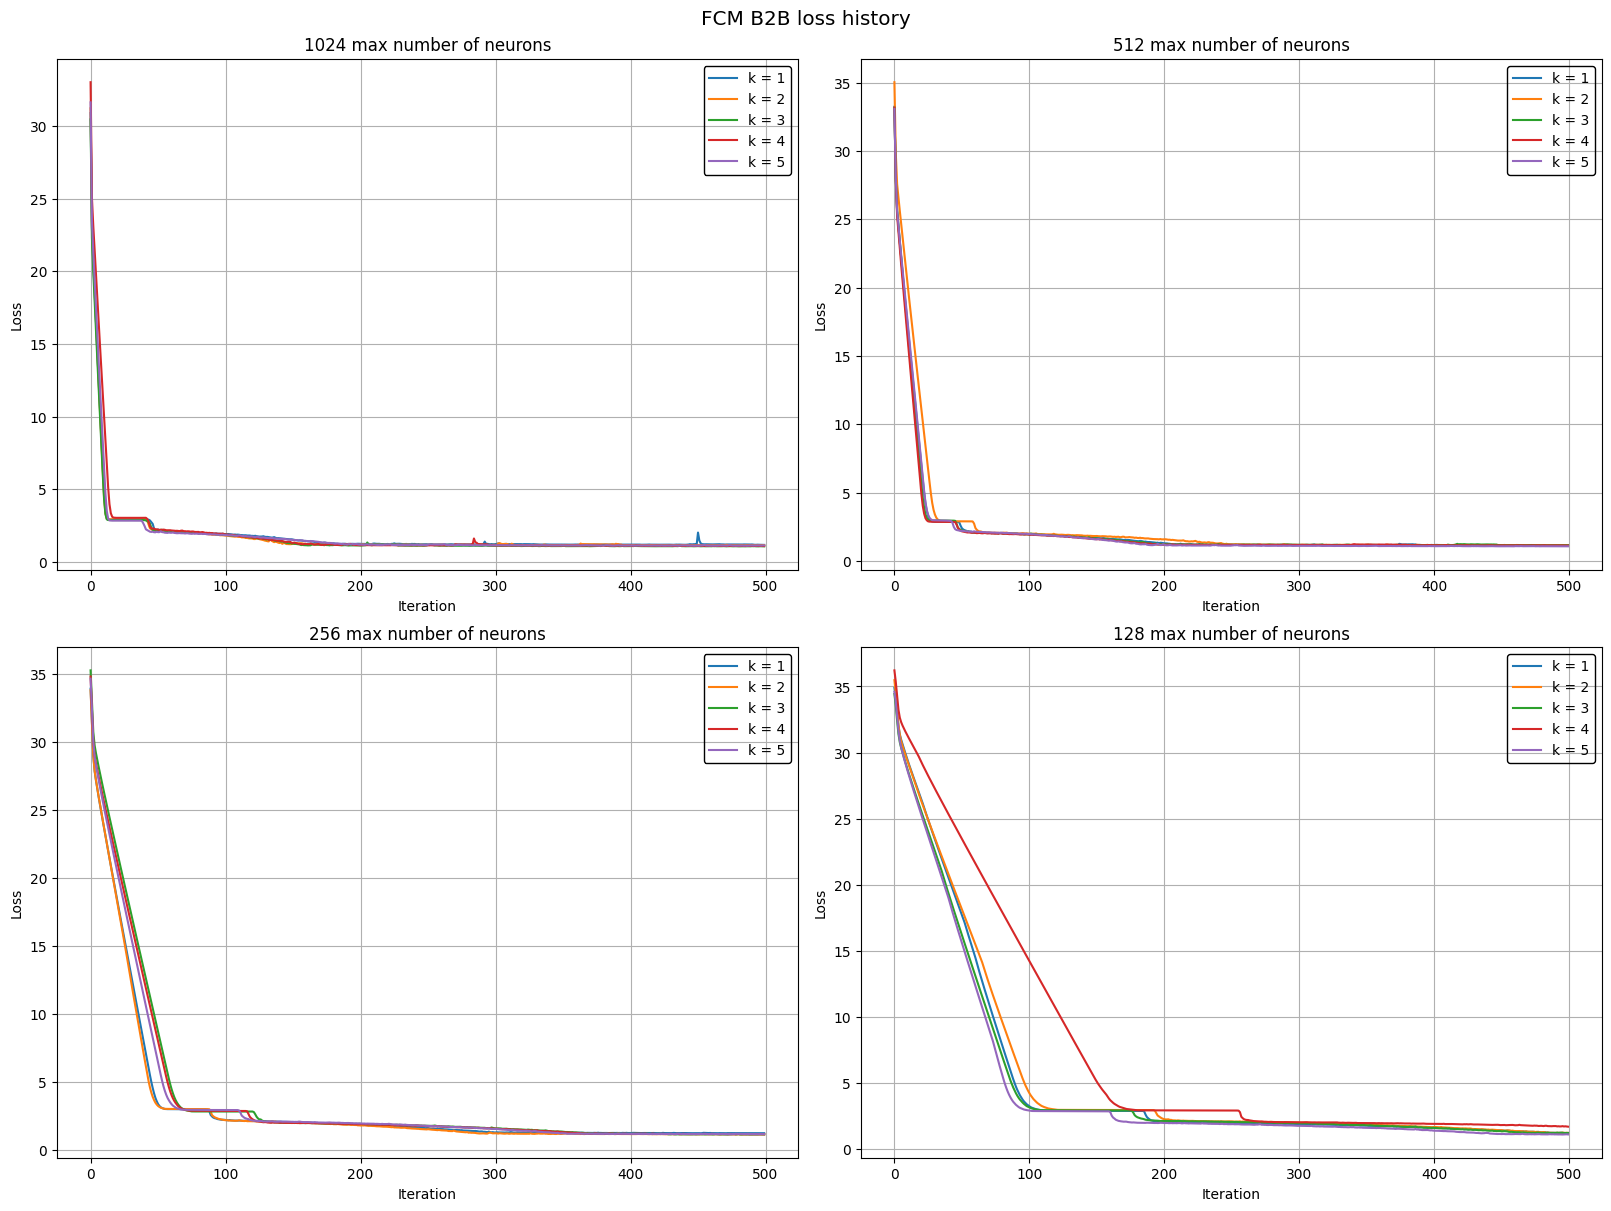

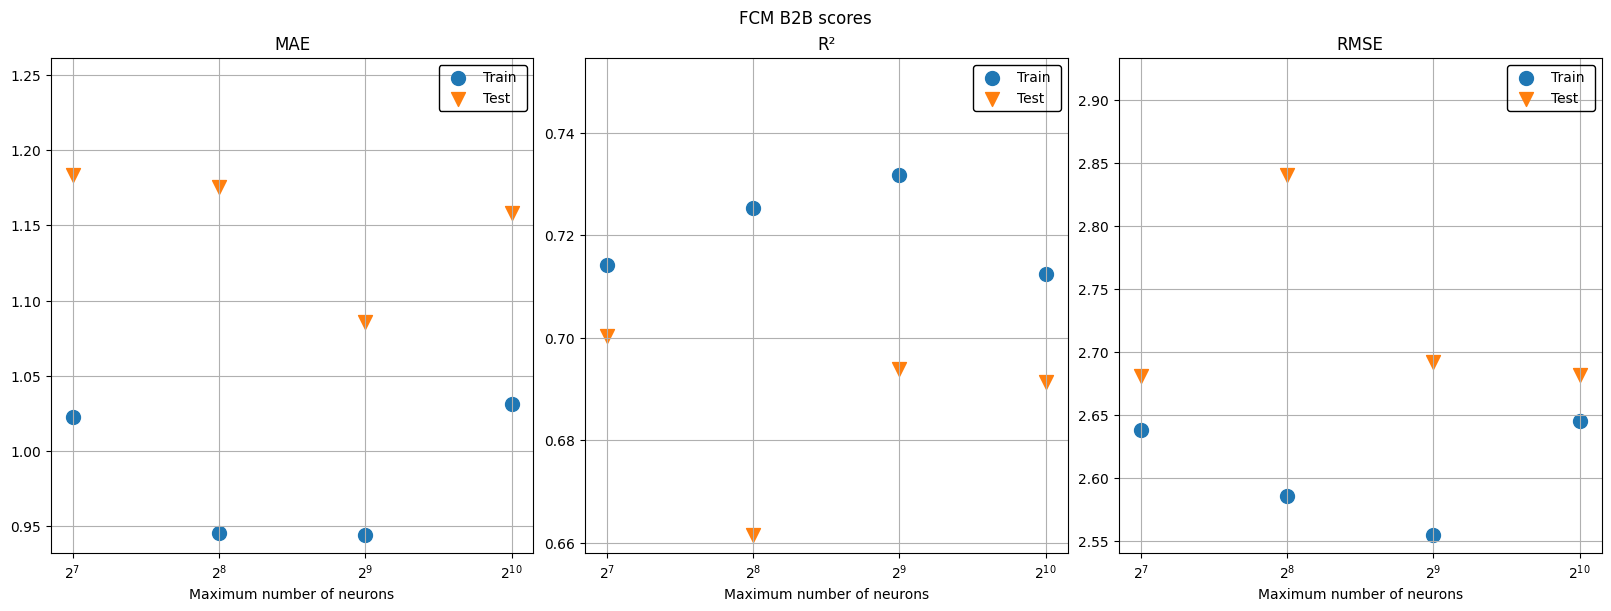

In [16]:
scores = [scores_FCM_1024_B2B, scores_FCM_512_B2B, scores_FCM_256_B2B, scores_FCM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM B2B")

### FCM con fibra óptica a 0dBm

In [17]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber0 = calc_once("scores_FCM_1024_fiber0", test_estimation_model, args)

In [18]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber0 = calc_once("scores_FCM_512_fiber0", test_estimation_model, args)

In [19]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber0 = calc_once("scores_FCM_256_fiber0", test_estimation_model, args)

In [20]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber0 = calc_once("scores_FCM_128_fiber0", test_estimation_model, args)

In [21]:
%store scores_FCM_1024_fiber0 
%store scores_FCM_512_fiber0 
%store scores_FCM_256_fiber0 
%store scores_FCM_128_fiber0

Stored 'scores_FCM_1024_fiber0' (dict)
Stored 'scores_FCM_512_fiber0' (dict)
Stored 'scores_FCM_256_fiber0' (dict)
Stored 'scores_FCM_128_fiber0' (dict)


#### Gráficas

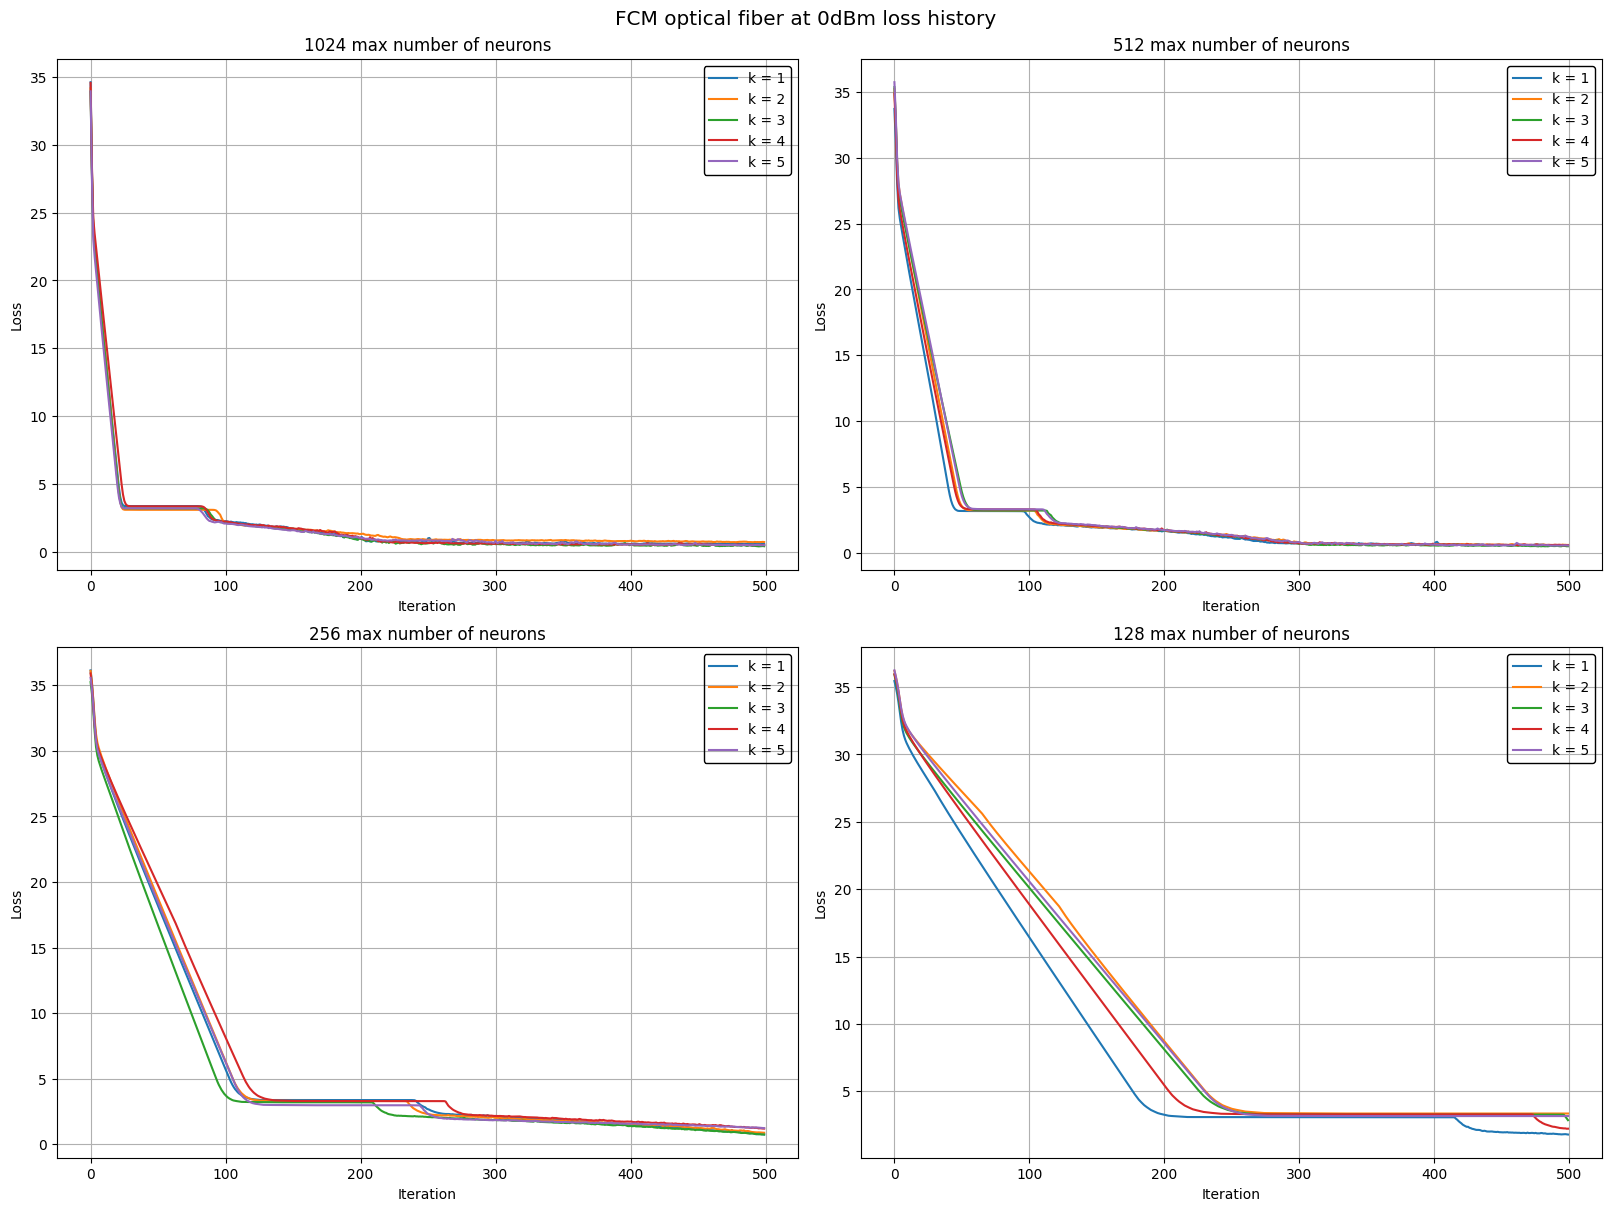

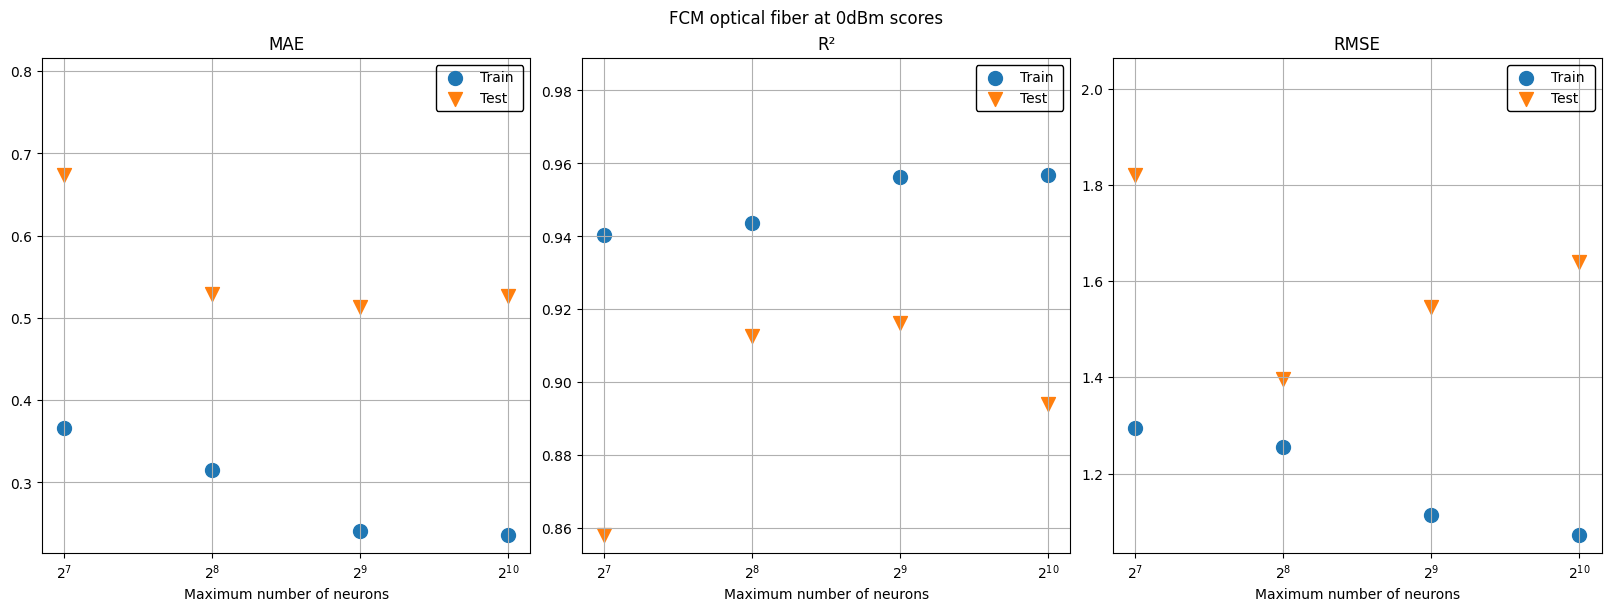

In [22]:
scores = [scores_FCM_1024_fiber0, scores_FCM_512_fiber0, scores_FCM_256_fiber0, scores_FCM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, scenario="FCM optical fiber at 0dBm")

### FCM con fibra óptica a 9dBm

In [23]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_1024_fiber9 = calc_once("scores_FCM_1024_fiber9", test_estimation_model, args)

In [24]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_512_fiber9 = calc_once("scores_FCM_512_fiber9", test_estimation_model, args)

In [25]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_256_fiber9 = calc_once("scores_FCM_256_fiber9", test_estimation_model, args)

In [26]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_128_fiber9 = calc_once("scores_FCM_128_fiber9", test_estimation_model, args)

In [27]:
%store scores_FCM_1024_fiber9
%store scores_FCM_512_fiber9 
%store scores_FCM_256_fiber9 
%store scores_FCM_128_fiber9

Stored 'scores_FCM_1024_fiber9' (dict)
Stored 'scores_FCM_512_fiber9' (dict)
Stored 'scores_FCM_256_fiber9' (dict)
Stored 'scores_FCM_128_fiber9' (dict)


#### Gráficas

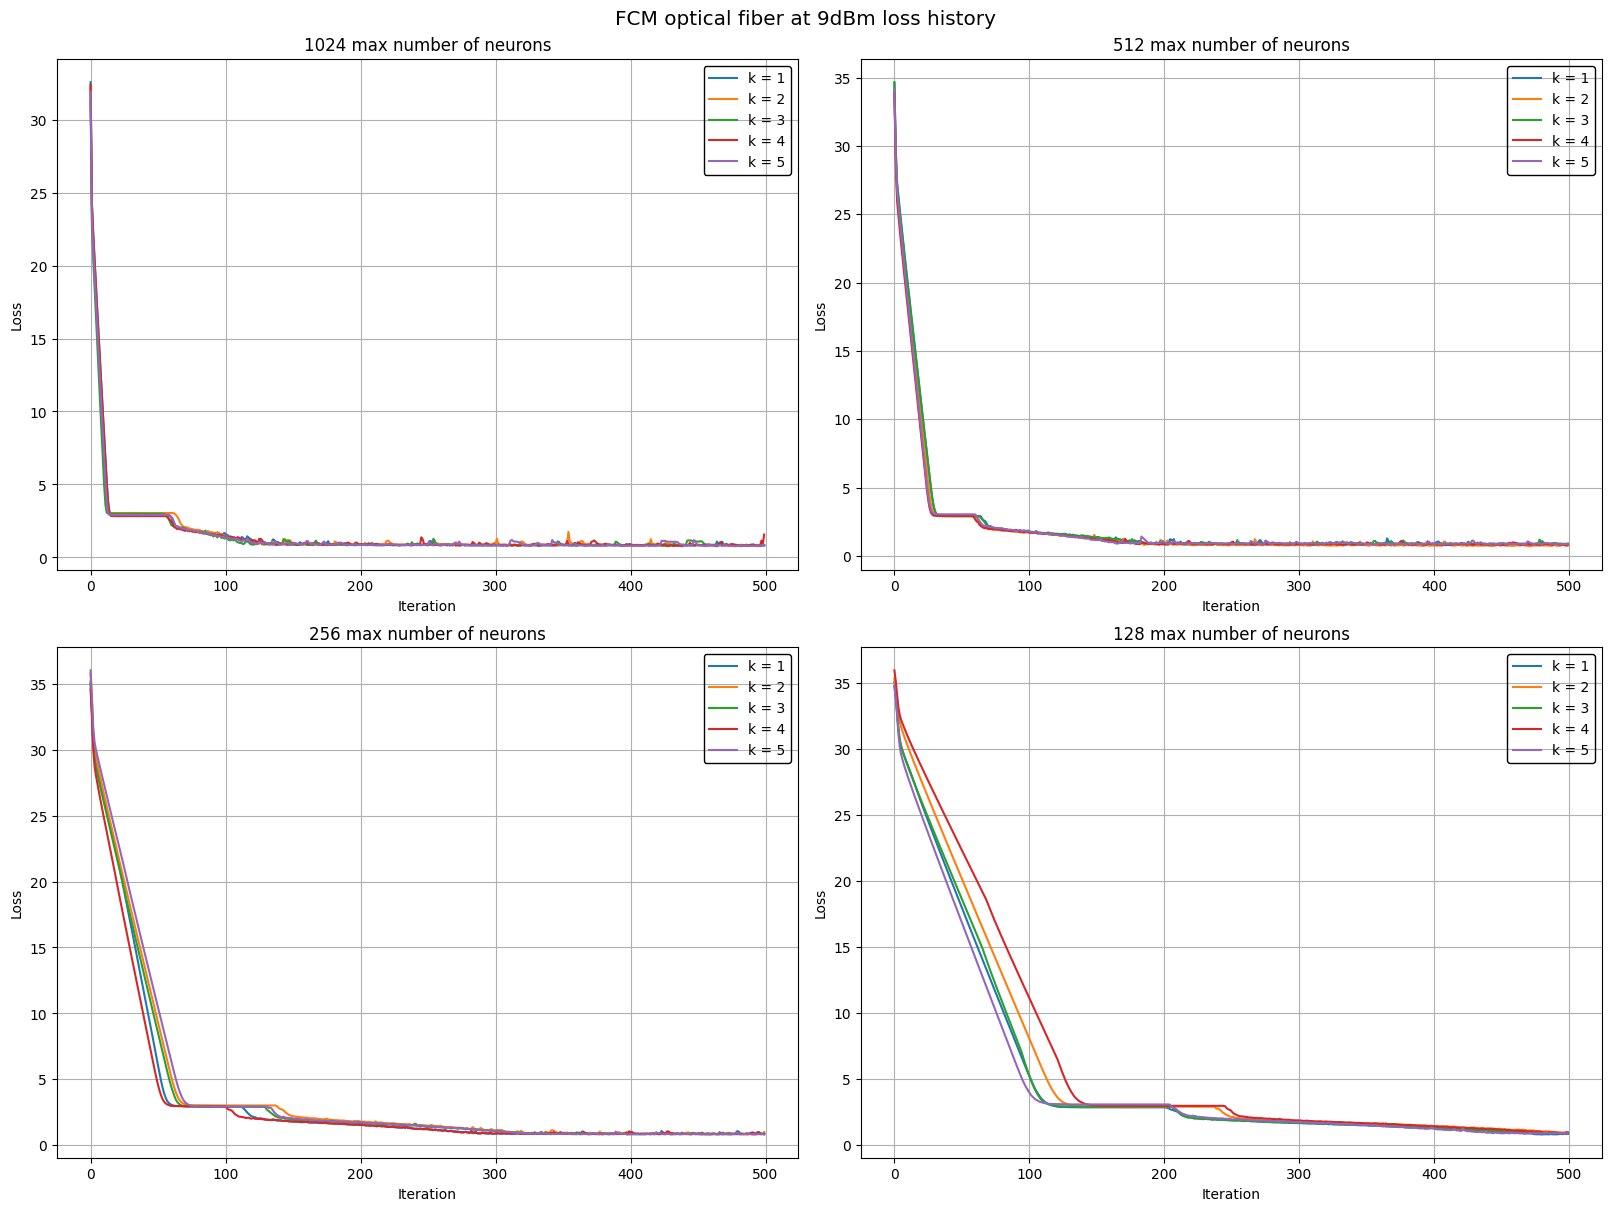

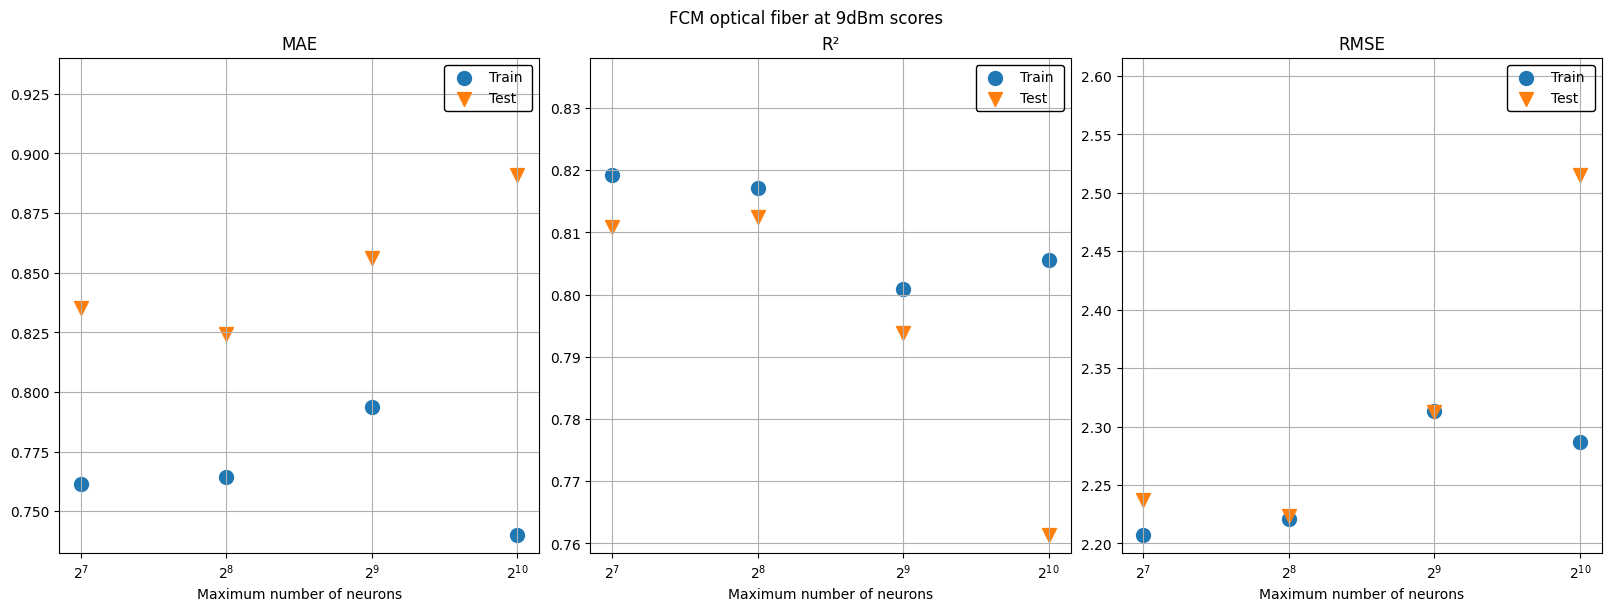

In [28]:
scores = [scores_FCM_1024_fiber9, scores_FCM_512_fiber9, scores_FCM_256_fiber9, scores_FCM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "FCM optical fiber at 9dBm")

### GKM B2B

In [29]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_B2B = calc_once("scores_GKM_1024_B2B", test_estimation_model, args)

In [30]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_B2B = calc_once("scores_GKM_512_B2B", test_estimation_model, args)

In [31]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_B2B = calc_once("scores_GKM_256_B2B", test_estimation_model, args)

In [32]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_B2B = calc_once("scores_GKM_128_B2B", test_estimation_model, args)

In [33]:
%store scores_GKM_1024_B2B
%store scores_GKM_512_B2B
%store scores_GKM_256_B2B
%store scores_GKM_128_B2B

Stored 'scores_GKM_1024_B2B' (dict)
Stored 'scores_GKM_512_B2B' (dict)
Stored 'scores_GKM_256_B2B' (dict)
Stored 'scores_GKM_128_B2B' (dict)


#### Gráficas

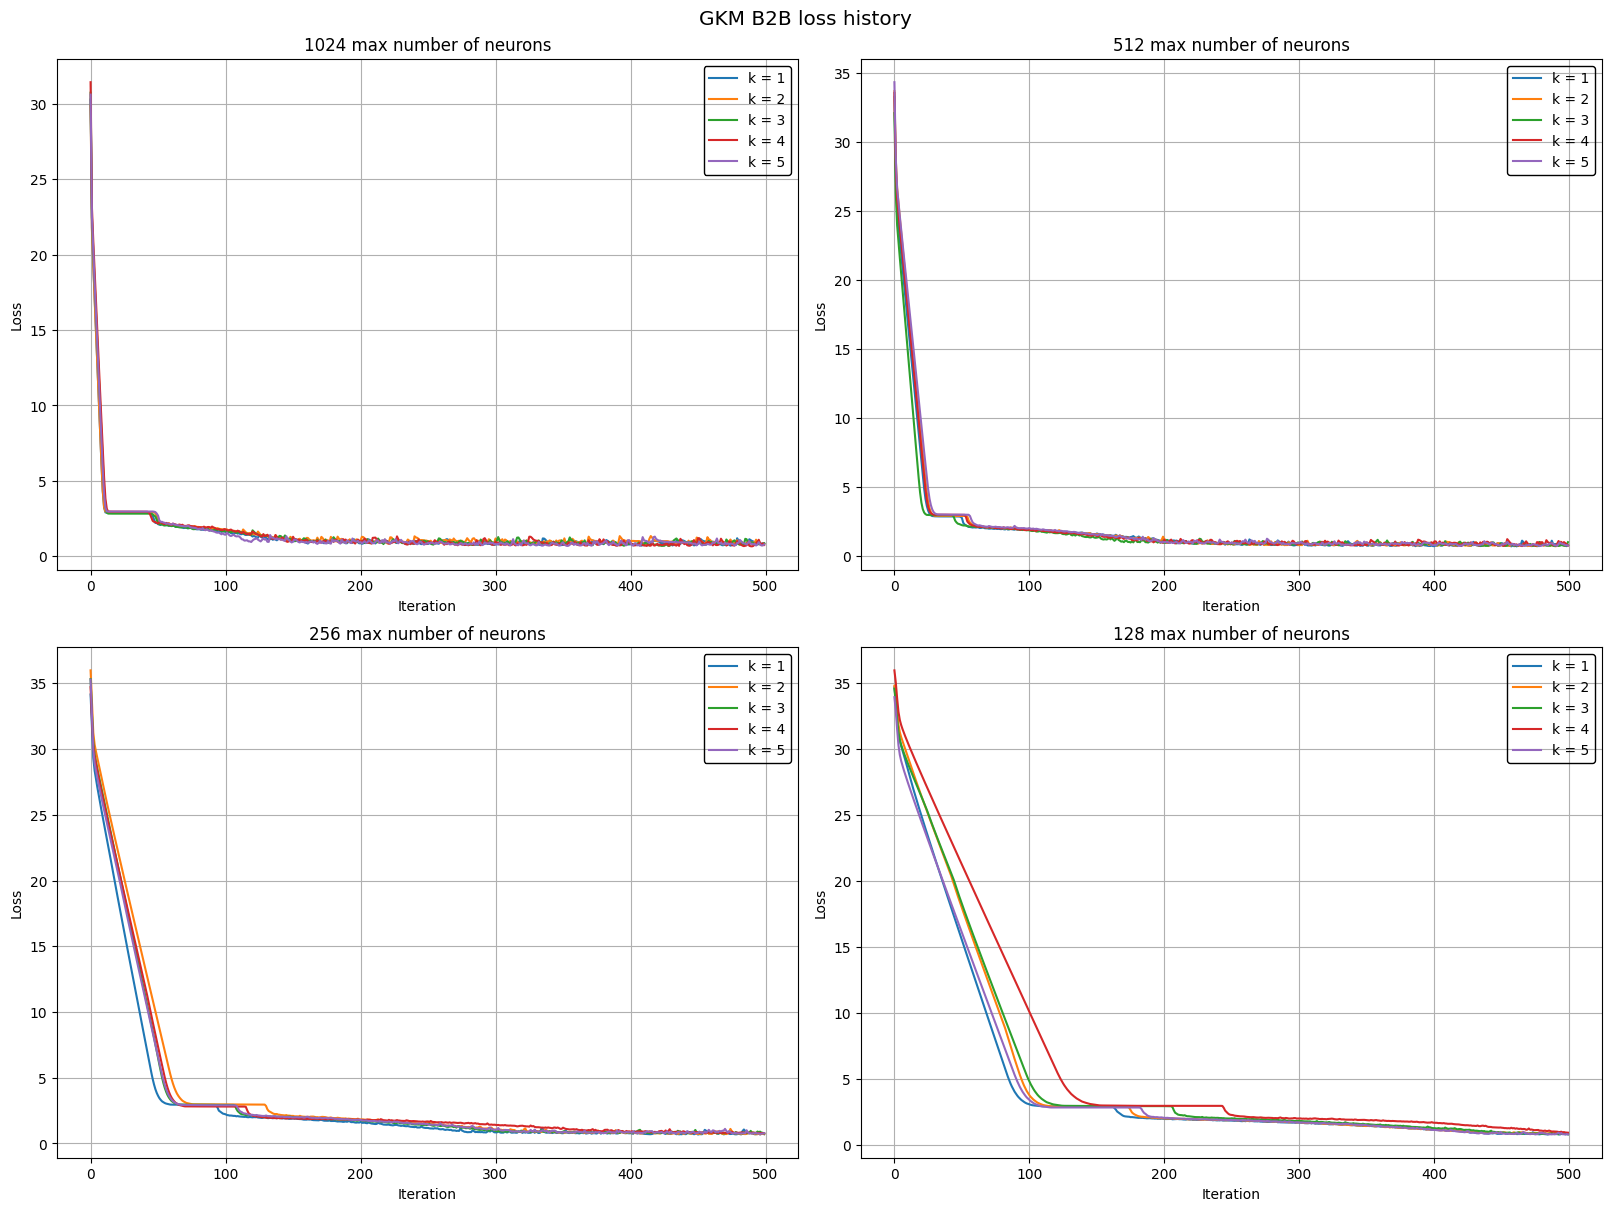

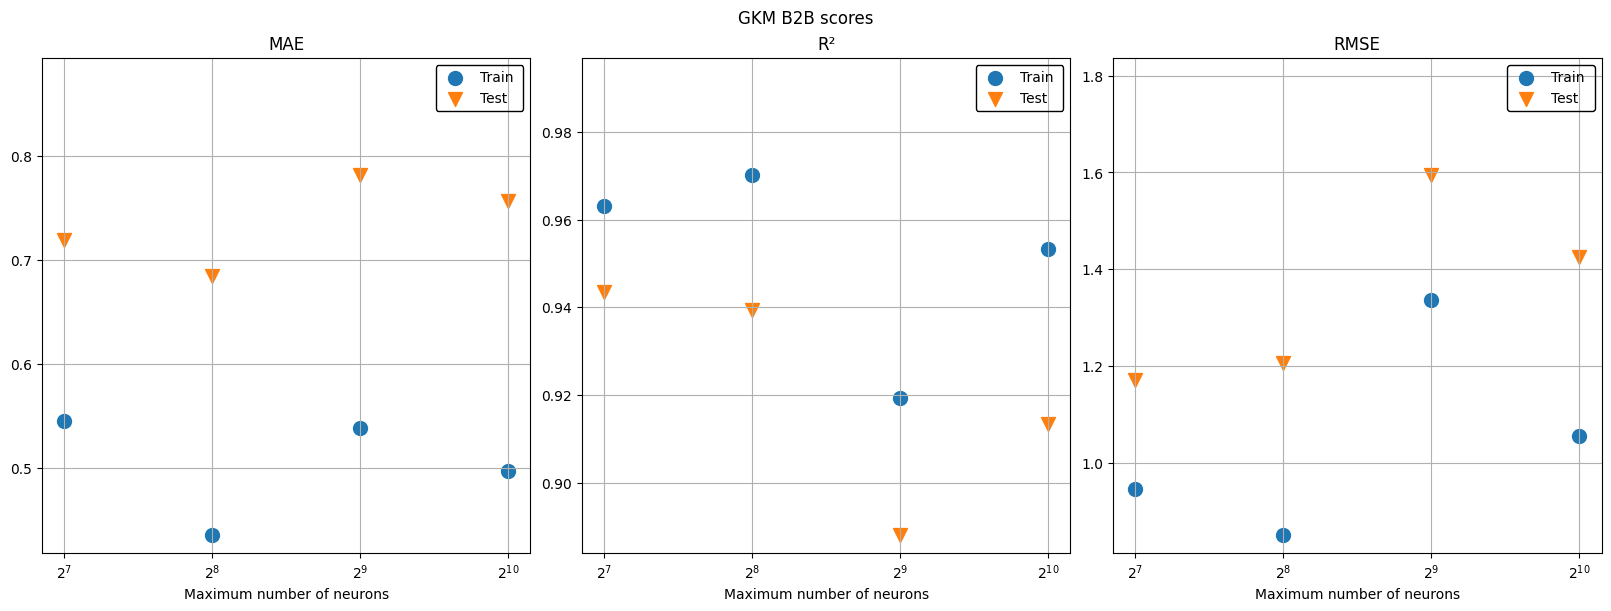

In [34]:
scores = [scores_GKM_1024_B2B, scores_GKM_512_B2B, scores_GKM_256_B2B, scores_GKM_128_B2B]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM B2B")

### GKM con fibra óptica a 0dBm

In [35]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber0 = calc_once("scores_GKM_1024_fiber0", test_estimation_model, args)

In [36]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber0 = calc_once("scores_GKM_512_fiber0", test_estimation_model, args)

In [37]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber0 = calc_once("scores_GKM_256_fiber0", test_estimation_model, args)

In [38]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber0 = calc_once("scores_GKM_128_fiber0", test_estimation_model, args)

In [39]:
%store scores_GKM_1024_fiber0
%store scores_GKM_512_fiber0
%store scores_GKM_256_fiber0
%store scores_GKM_128_fiber0

Stored 'scores_GKM_1024_fiber0' (dict)
Stored 'scores_GKM_512_fiber0' (dict)
Stored 'scores_GKM_256_fiber0' (dict)
Stored 'scores_GKM_128_fiber0' (dict)


#### Gráficas

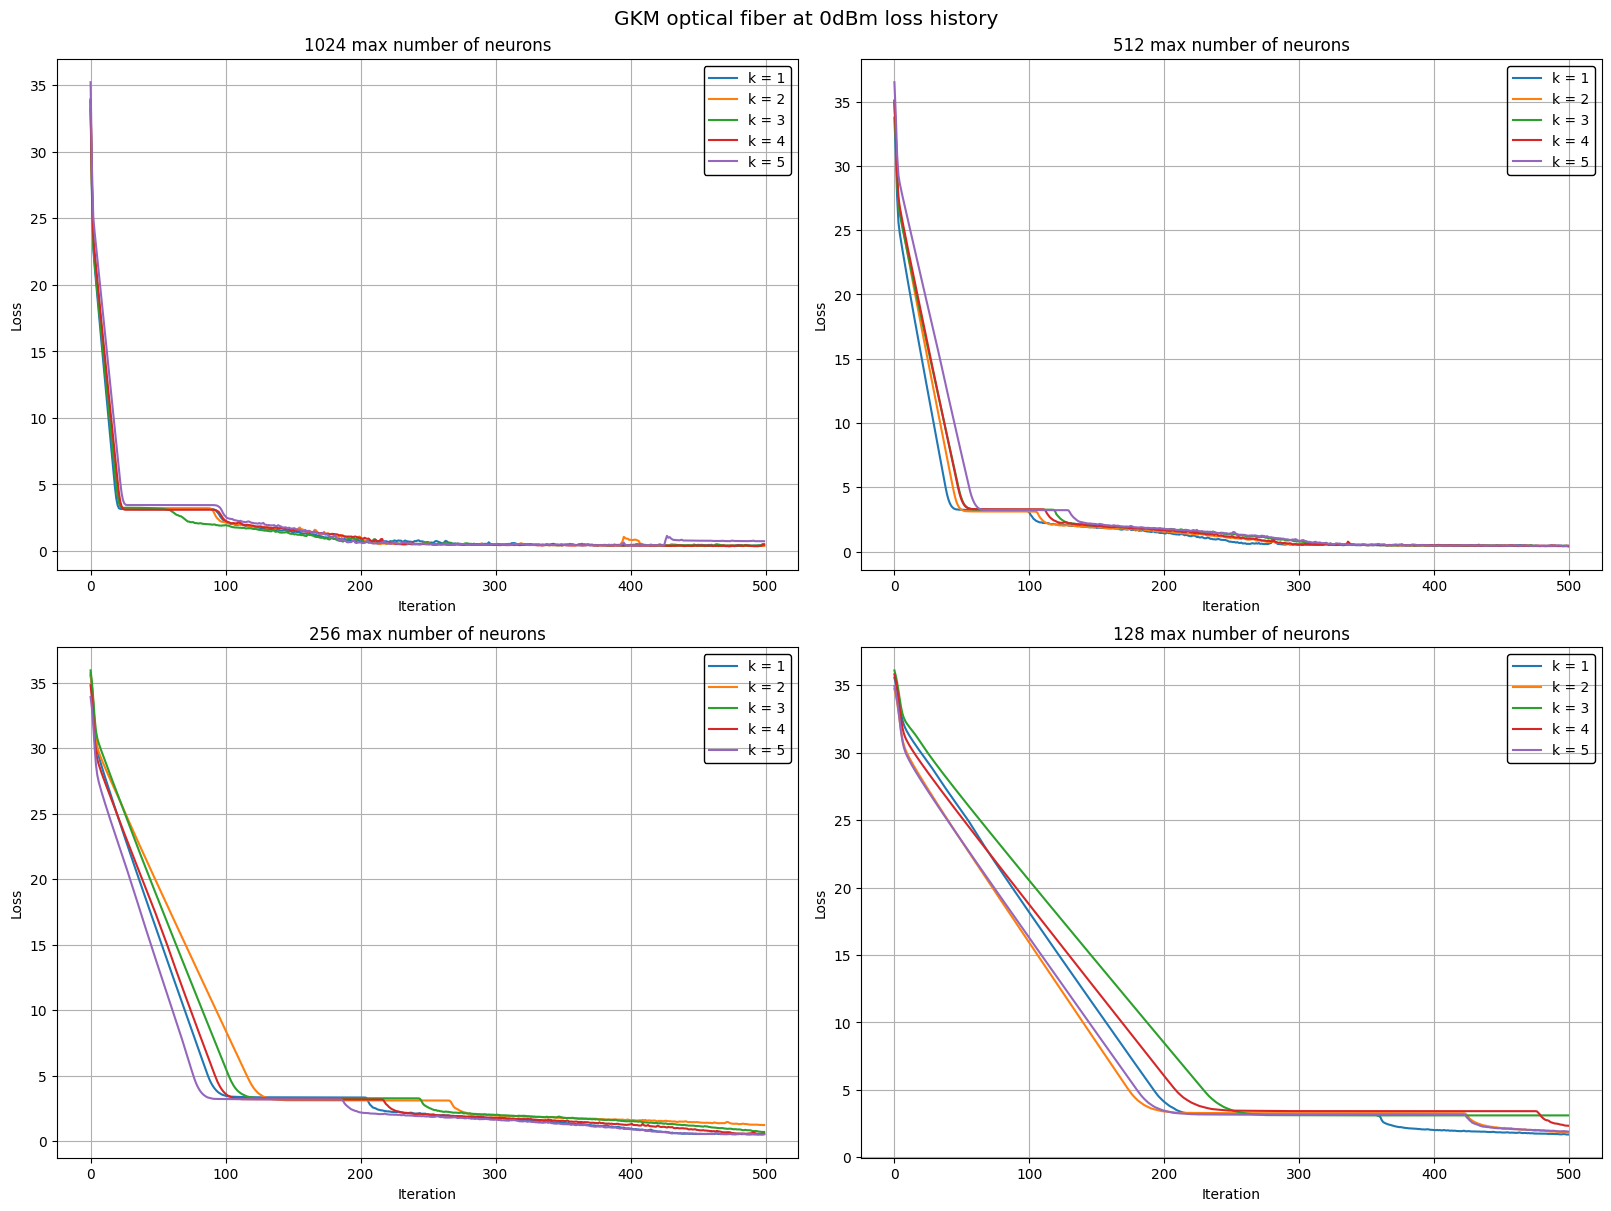

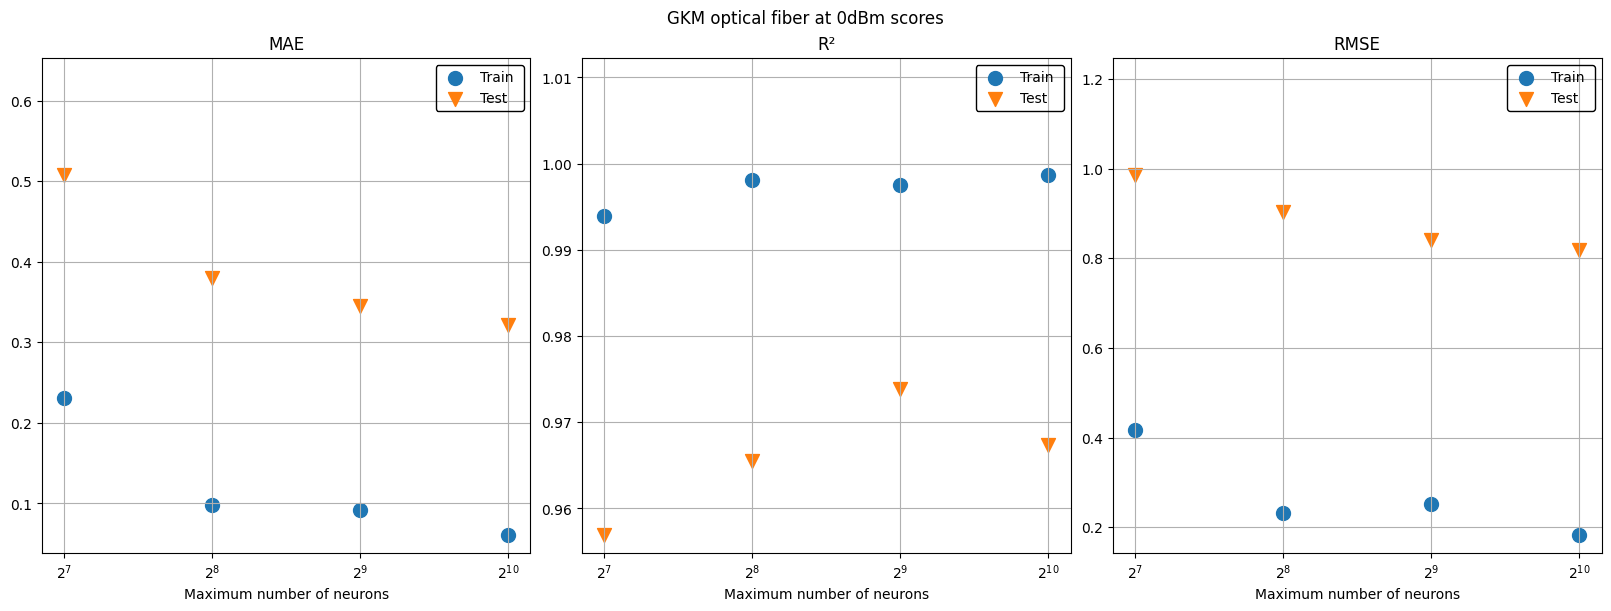

In [40]:
scores = [scores_GKM_1024_fiber0, scores_GKM_512_fiber0, scores_GKM_256_fiber0, scores_GKM_128_fiber0]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 0dBm")

### GKM con fibra óptica a 9dBm

In [41]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 1024, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_1024_fiber9 = calc_once("scores_GKM_1024_fiber9", test_estimation_model, args)

In [42]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_512_fiber9 = calc_once("scores_GKM_512_fiber9", test_estimation_model, args)

In [43]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_256_fiber9 = calc_once("scores_GKM_256_fiber9", test_estimation_model, args)

In [44]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 128, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_128_fiber9 = calc_once("scores_GKM_128_fiber9", test_estimation_model, args)

In [45]:
%store scores_GKM_1024_fiber9
%store scores_GKM_512_fiber9
%store scores_GKM_256_fiber9
%store scores_GKM_128_fiber9

Stored 'scores_GKM_1024_fiber9' (dict)
Stored 'scores_GKM_512_fiber9' (dict)
Stored 'scores_GKM_256_fiber9' (dict)
Stored 'scores_GKM_128_fiber9' (dict)


#### Gráficas

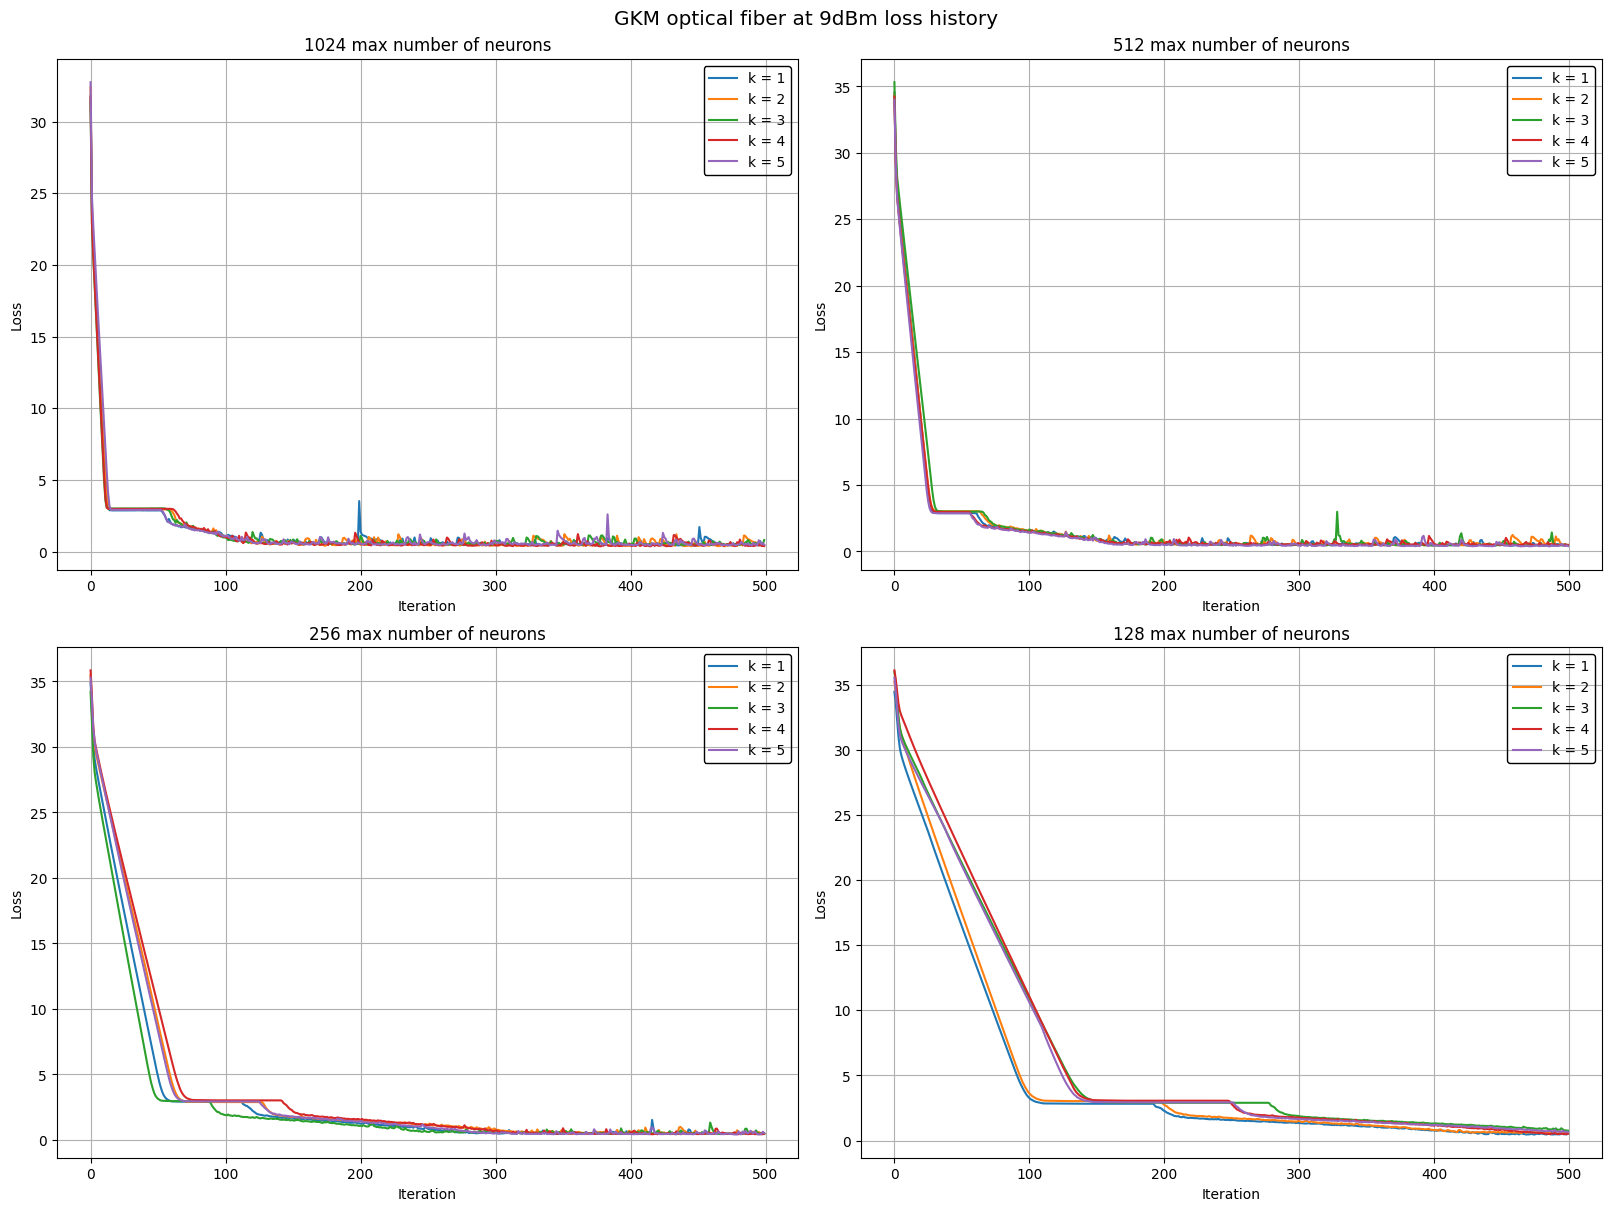

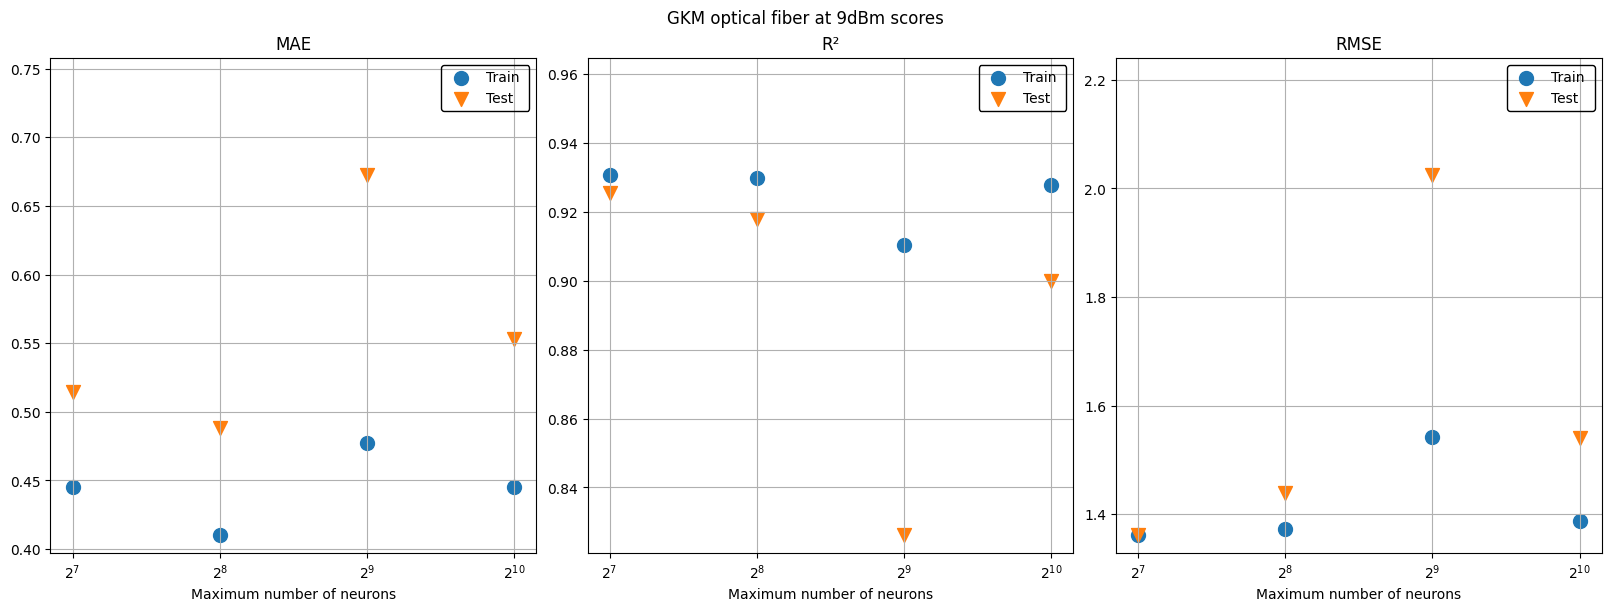

In [46]:
scores = [scores_GKM_1024_fiber9, scores_GKM_512_fiber9, scores_GKM_256_fiber9, scores_GKM_128_fiber9]
max_neurons = [1024, 512, 256, 128]
plot_neurons_scores(scores, max_neurons, "GKM optical fiber at 9dBm")

## Comparación variando la primera función de activación (ReLu vs. Swish)

### B2B

In [47]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_B2B = calc_once("scores_FCM_relu_B2B", test_estimation_model, args)

In [48]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_B2B = calc_once("scores_GKM_relu_B2B", test_estimation_model, args)

In [49]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_B2B = calc_once("scores_FCM_swish_B2B", test_estimation_model, args)

In [50]:
args = {"data": df_GKM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_B2B = calc_once("scores_GKM_swish_B2B", test_estimation_model, args)

In [51]:
%store scores_FCM_relu_B2B
%store scores_GKM_relu_B2B
%store scores_FCM_swish_B2B
%store scores_GKM_swish_B2B

Stored 'scores_FCM_relu_B2B' (dict)
Stored 'scores_GKM_relu_B2B' (dict)
Stored 'scores_FCM_swish_B2B' (dict)
Stored 'scores_GKM_swish_B2B' (dict)


In [52]:
#scores = [scores_FCM_relu_B2B, scores_GKM_relu_B2B, scores_FCM_swish_B2B, scores_GKM_swish_B2B]
#plot_activations_scores(scores, "ReLu vs. Swish, B2B")

### Fibra óptica a 0dBm

In [53]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber0 = calc_once("scores_FCM_relu_fiber0", test_estimation_model, args)

In [54]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber0 = calc_once("scores_GKM_relu_fiber0", test_estimation_model, args)

In [55]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber0 = calc_once("scores_FCM_swish_fiber0", test_estimation_model, args)

In [56]:
args = {"data": df_GKM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber0 = calc_once("scores_GKM_swish_fiber0", test_estimation_model, args)

In [57]:
%store scores_FCM_relu_fiber0
%store scores_GKM_relu_fiber0
%store scores_FCM_swish_fiber0
%store scores_GKM_swish_fiber0

Stored 'scores_FCM_relu_fiber0' (dict)
Stored 'scores_GKM_relu_fiber0' (dict)
Stored 'scores_FCM_swish_fiber0' (dict)
Stored 'scores_GKM_swish_fiber0' (dict)


In [58]:
#scores = [scores_FCM_relu_fiber0, scores_GKM_relu_fiber0, scores_FCM_swish_fiber0, scores_GKM_swish_fiber0]
#plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 0dBm")

### Fibra óptica a 9dBm

In [59]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_relu_fiber9 = calc_once("scores_FCM_relu_fiber9", test_estimation_model, args)

In [60]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_GKM_relu_fiber9 = calc_once("scores_GKM_relu_fiber9", test_estimation_model, args)

In [61]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_FCM_swish_fiber9 = calc_once("scores_FCM_swish_fiber9", test_estimation_model, args)

In [62]:
args = {"data": df_GKM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["swish", "tanh", "sigmoid"]}
scores_GKM_swish_fiber9 = calc_once("scores_GKM_swish_fiber9", test_estimation_model, args)

In [63]:
%store scores_FCM_relu_fiber9
%store scores_GKM_relu_fiber9
%store scores_FCM_swish_fiber9
%store scores_GKM_swish_fiber9

Stored 'scores_FCM_relu_fiber9' (dict)
Stored 'scores_GKM_relu_fiber9' (dict)
Stored 'scores_FCM_swish_fiber9' (dict)
Stored 'scores_GKM_swish_fiber9' (dict)


In [64]:
#scores = [scores_FCM_relu_fiber9, scores_GKM_relu_fiber9, scores_FCM_swish_fiber9, scores_GKM_swish_fiber9]
#plot_activations_scores(scores, "ReLu vs. Swish, optical fiber at 9dBm")

## Comparación variando el número de capas ocultas

### B2B

In [65]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_B2B_1HL = calc_once("scores_FCM_B2B_1HL", test_estimation_model, args)

In [66]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_B2B_2HL = calc_once("scores_FCM_B2B_2HL", test_estimation_model, args)

In [67]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_B2B_3HL = calc_once("scores_FCM_B2B_3HL", test_estimation_model, args)

In [68]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_B2B_4HL = calc_once("scores_FCM_B2B_4HL", test_estimation_model, args)

In [69]:
%store scores_FCM_B2B_1HL
%store scores_FCM_B2B_2HL
%store scores_FCM_B2B_3HL
%store scores_FCM_B2B_4HL

Stored 'scores_FCM_B2B_1HL' (dict)
Stored 'scores_FCM_B2B_2HL' (dict)
Stored 'scores_FCM_B2B_3HL' (dict)
Stored 'scores_FCM_B2B_4HL' (dict)


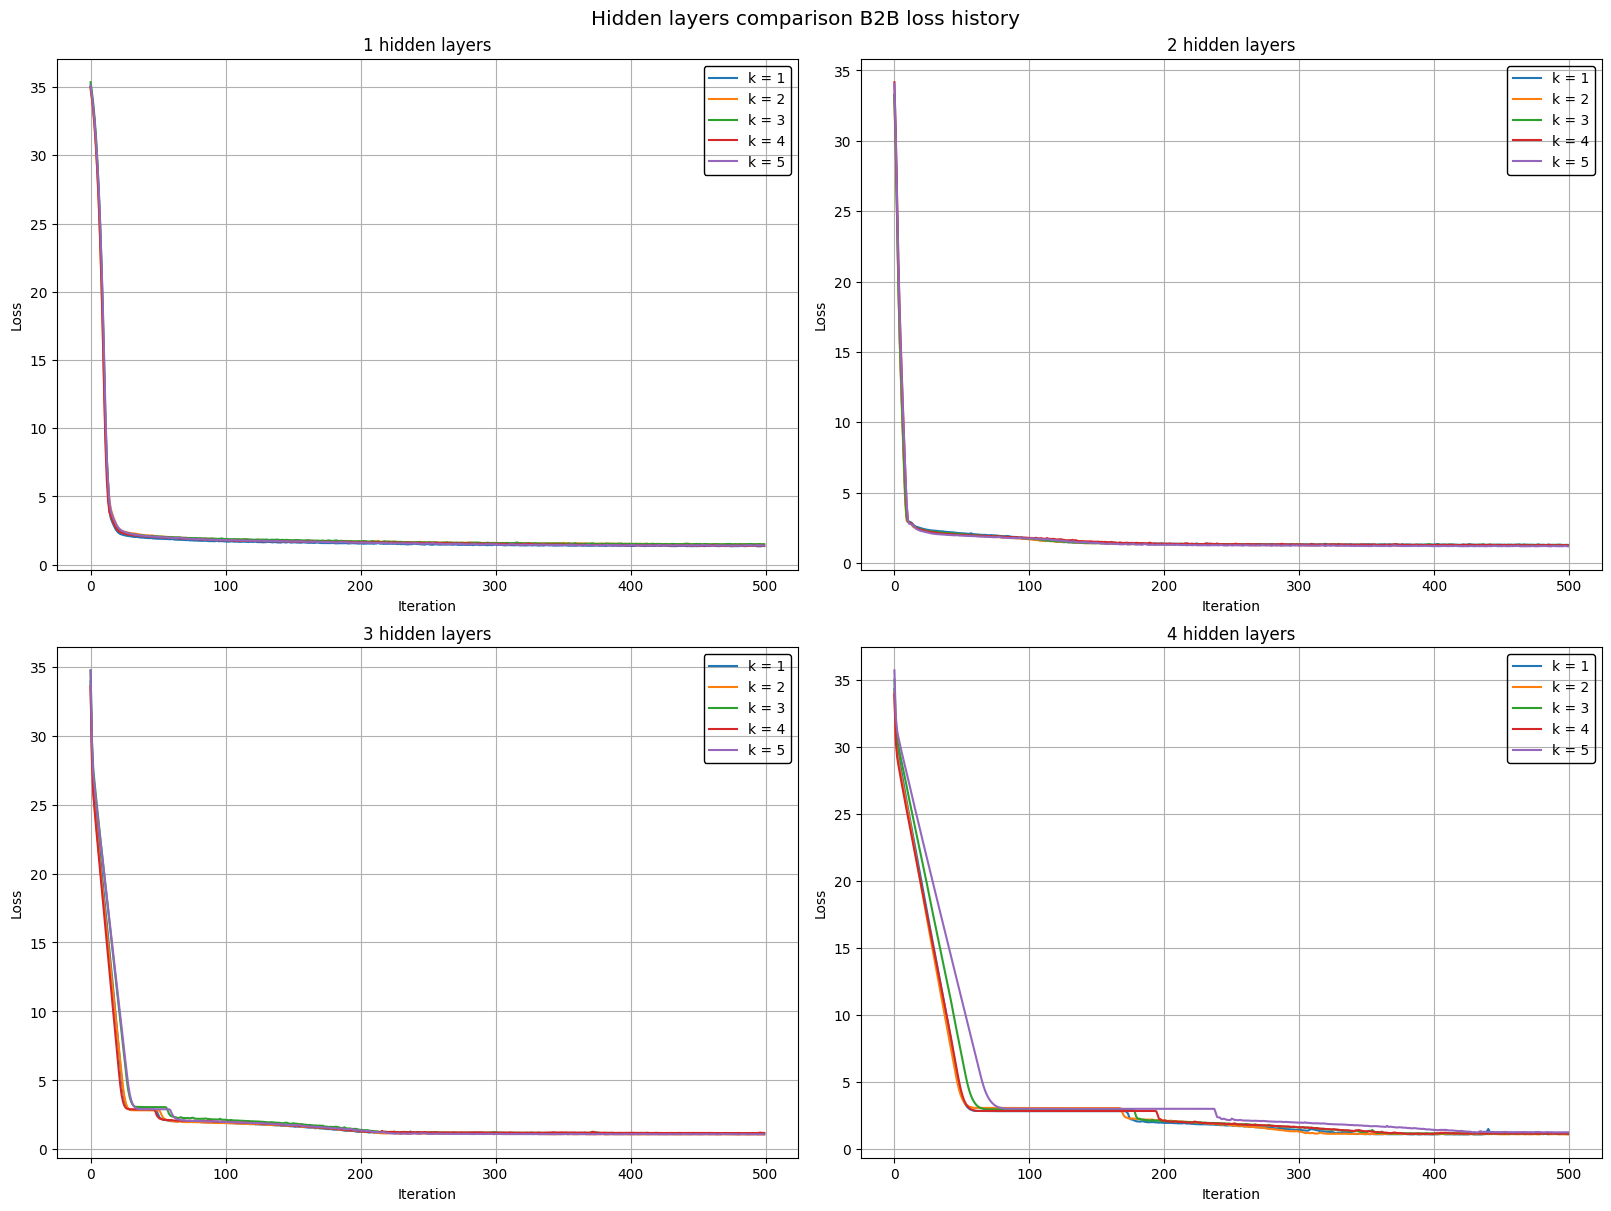

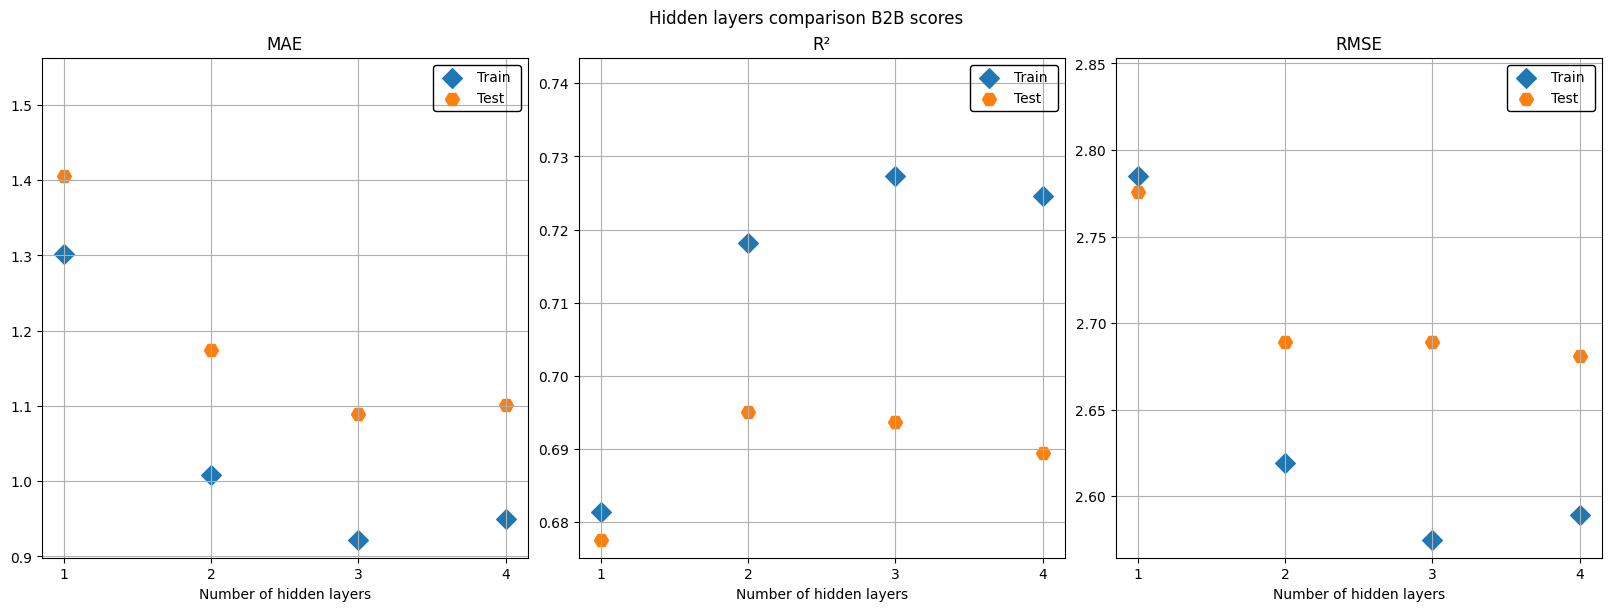

In [70]:
scores = [scores_FCM_B2B_1HL, scores_FCM_B2B_2HL, scores_FCM_B2B_3HL, scores_FCM_B2B_4HL]
plot_layers_scores(scores, "Hidden layers comparison B2B")

### Fibra óptica a 0dBm

In [71]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber0_1HL = calc_once("scores_FCM_fiber0_1HL", test_estimation_model, args)

In [72]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber0_2HL = calc_once("scores_FCM_fiber0_2HL", test_estimation_model, args)

In [73]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_3HL = calc_once("scores_FCM_fiber0_3HL", test_estimation_model, args)

In [74]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber0_4HL = calc_once("scores_FCM_fiber0_4HL", test_estimation_model, args)

In [75]:
%store scores_FCM_fiber0_1HL
%store scores_FCM_fiber0_2HL
%store scores_FCM_fiber0_3HL
%store scores_FCM_fiber0_4HL

Stored 'scores_FCM_fiber0_1HL' (dict)
Stored 'scores_FCM_fiber0_2HL' (dict)
Stored 'scores_FCM_fiber0_3HL' (dict)
Stored 'scores_FCM_fiber0_4HL' (dict)


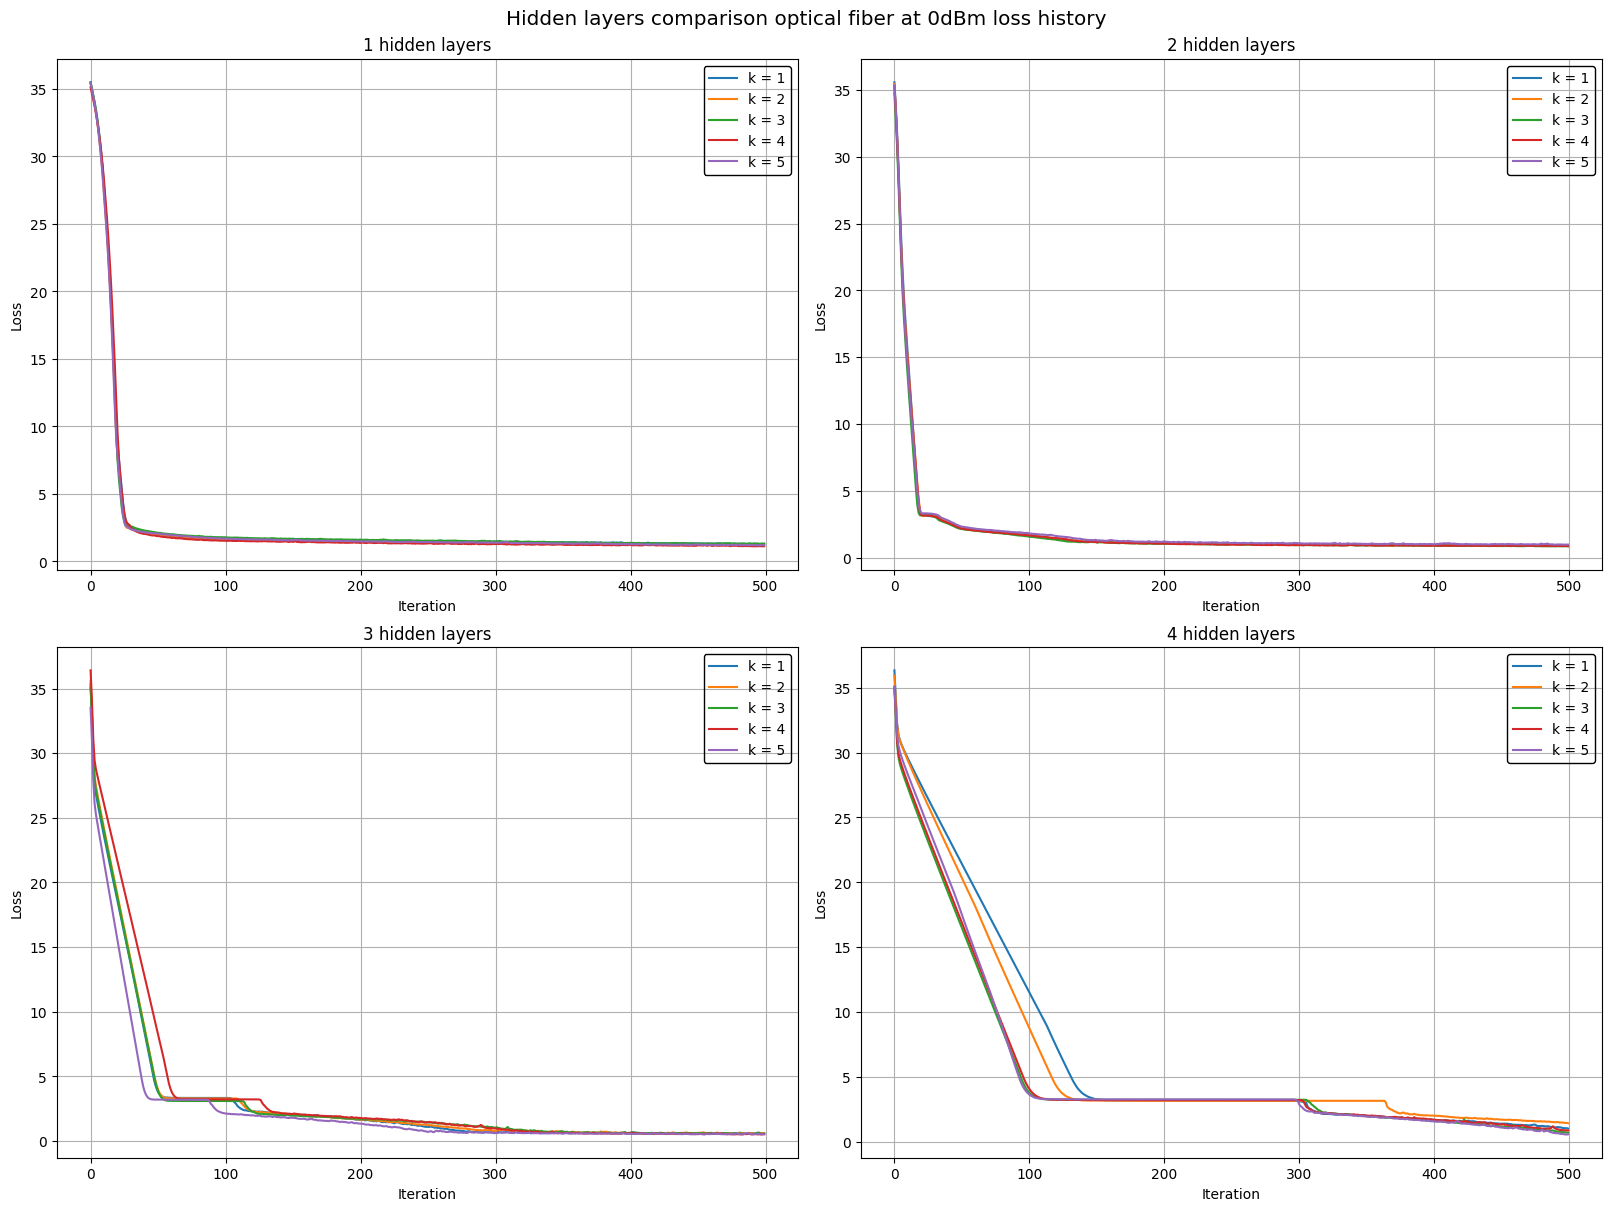

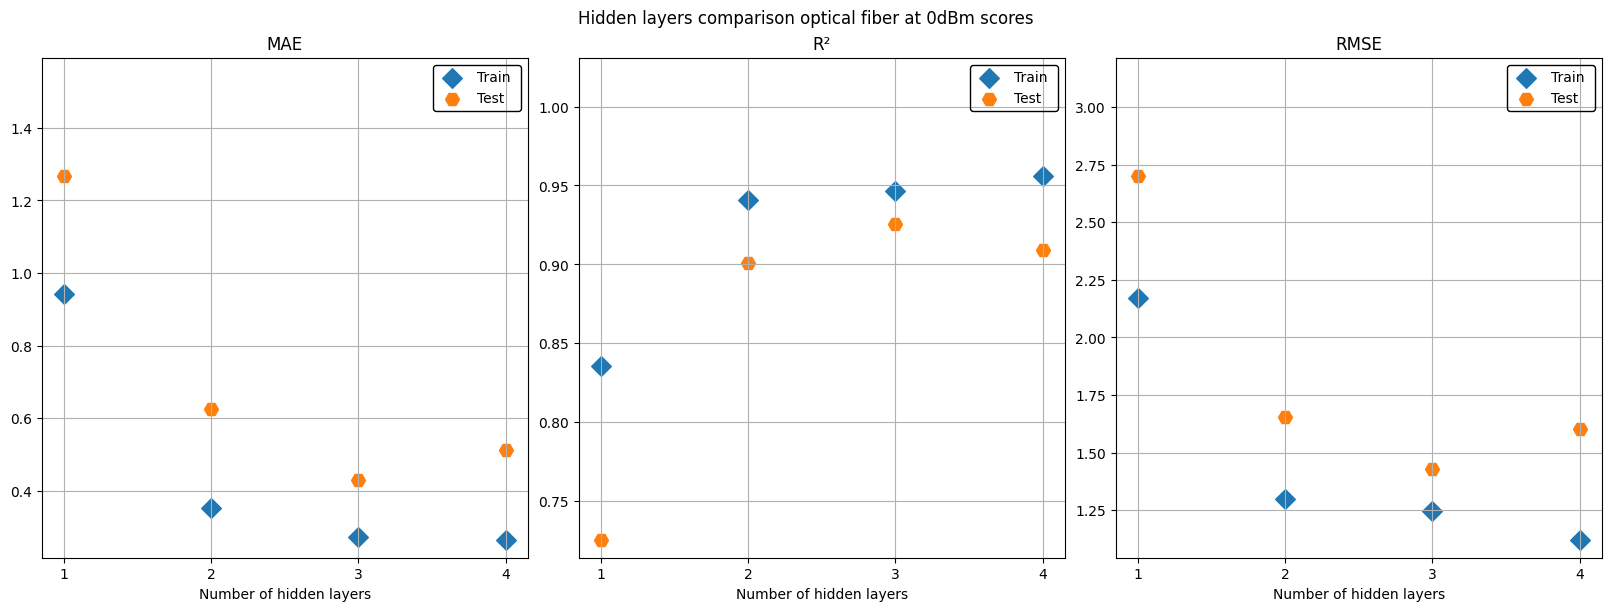

In [76]:
scores = [scores_FCM_fiber0_1HL, scores_FCM_fiber0_2HL, scores_FCM_fiber0_3HL, scores_FCM_fiber0_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 0dBm")

### Fibra óptica a 9dBm

In [77]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu"]}
scores_FCM_fiber9_1HL = calc_once("scores_FCM_fiber9_1HL", test_estimation_model, args)

In [78]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "sigmoid"]}
scores_FCM_fiber9_2HL = calc_once("scores_FCM_fiber9_2HL", test_estimation_model, args)

In [79]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_3HL = calc_once("scores_FCM_fiber9_3HL", test_estimation_model, args)

In [80]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 512, "activations": ["relu", "relu", "tanh", "sigmoid"]}
scores_FCM_fiber9_4HL = calc_once("scores_FCM_fiber9_4HL", test_estimation_model, args)

In [81]:
%store scores_FCM_fiber9_1HL
%store scores_FCM_fiber9_2HL
%store scores_FCM_fiber9_3HL
%store scores_FCM_fiber9_4HL

Stored 'scores_FCM_fiber9_1HL' (dict)
Stored 'scores_FCM_fiber9_2HL' (dict)
Stored 'scores_FCM_fiber9_3HL' (dict)
Stored 'scores_FCM_fiber9_4HL' (dict)


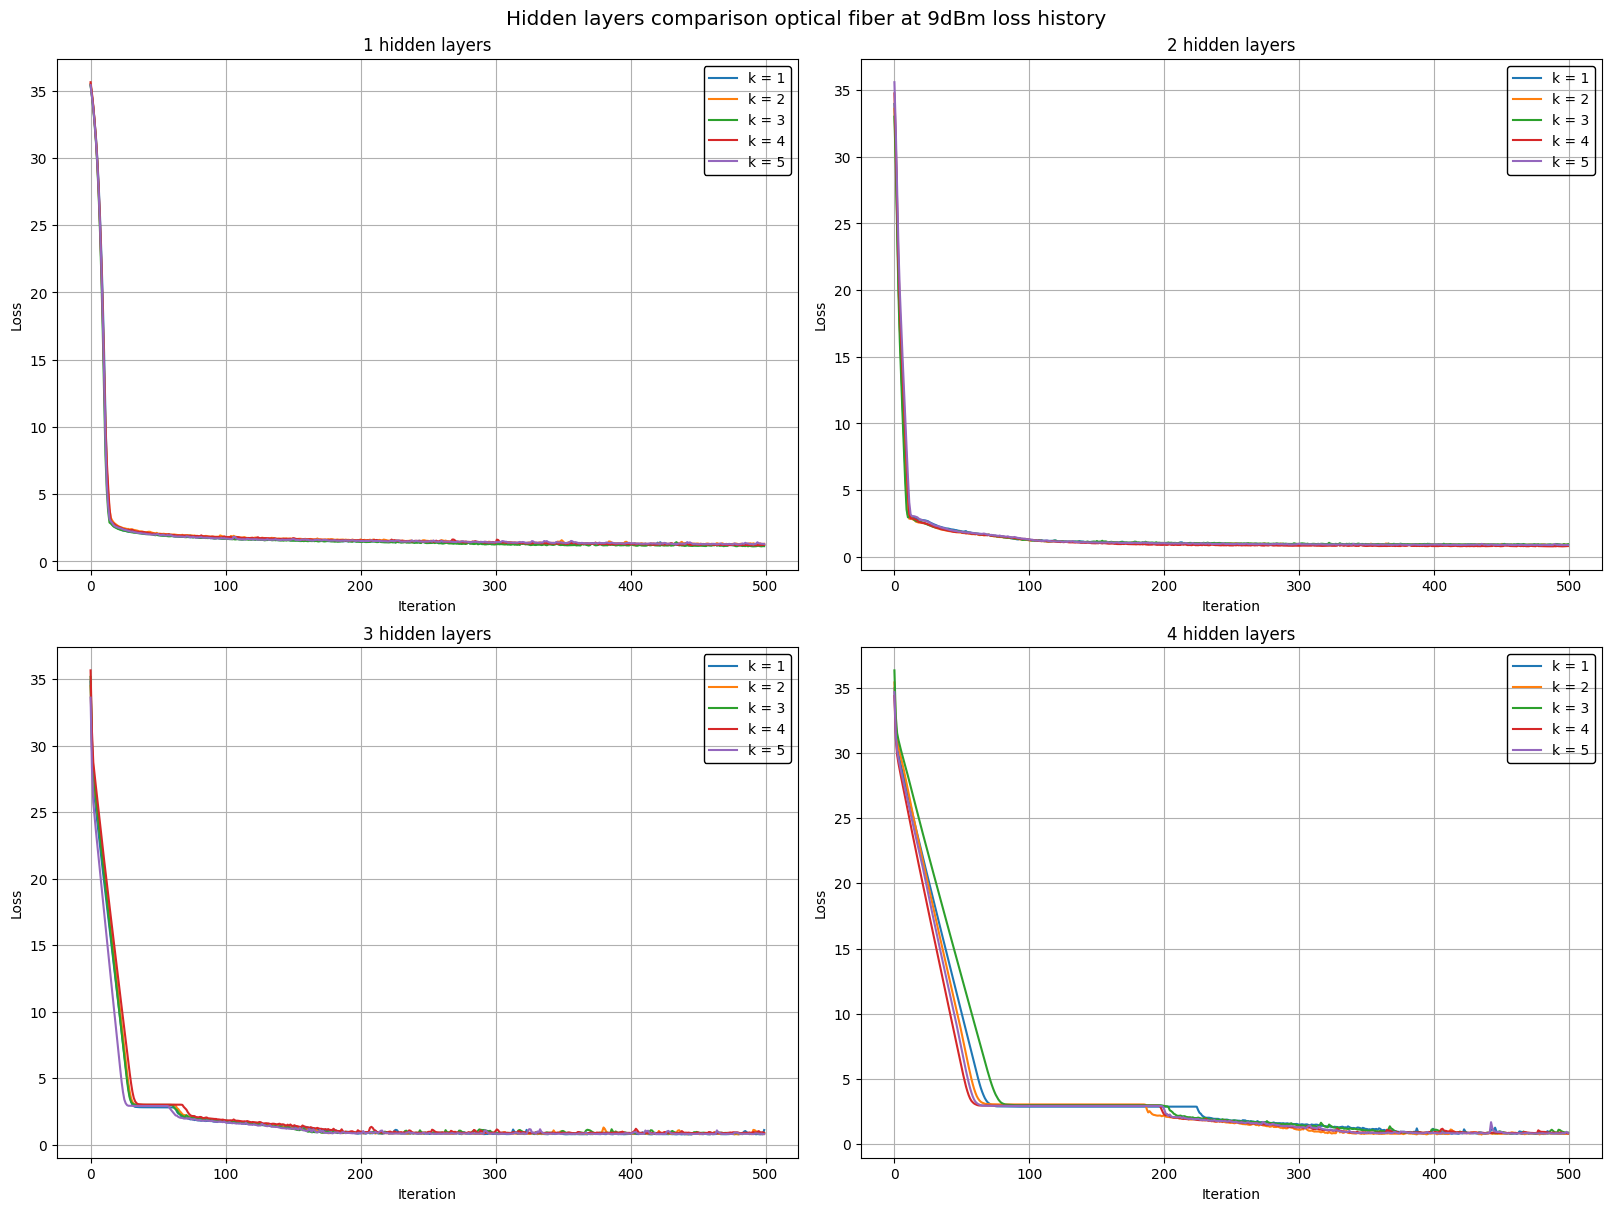

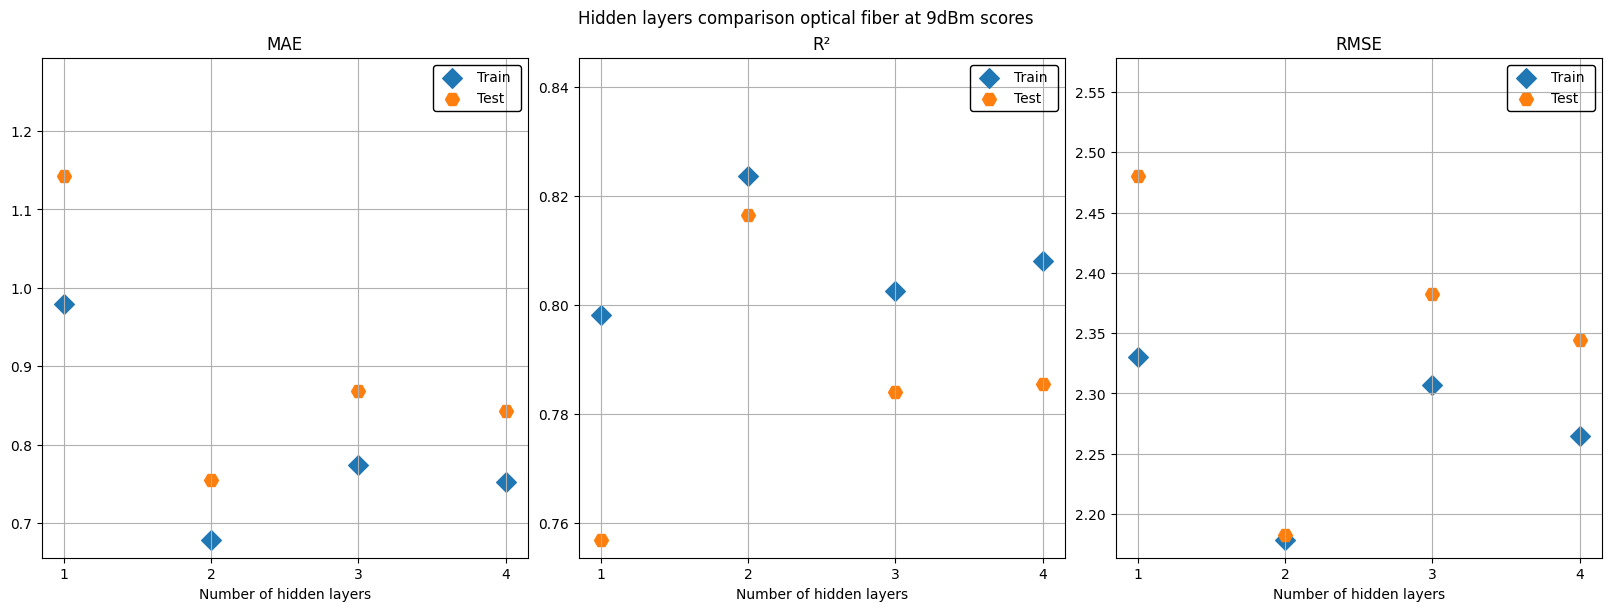

In [82]:
scores = [scores_FCM_fiber9_1HL, scores_FCM_fiber9_2HL, scores_FCM_fiber9_3HL, scores_FCM_fiber9_4HL]
plot_layers_scores(scores, "Hidden layers comparison optical fiber at 9dBm")

## Comparación variando la función de pérdida (MAE vs. RMSE)

In [83]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_B2B = calc_once("scores_FCM_MAE_B2B", test_estimation_model, args)

In [84]:
args = {"data": df_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_B2B = calc_once("scores_FCM_MSE_B2B", test_estimation_model, args)

In [85]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_fiber0 = calc_once("scores_FCM_MAE_fiber0", test_estimation_model, args)

In [86]:
args = {"data": df_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_fiber0 = calc_once("scores_FCM_MSE_fiber0", test_estimation_model, args)

In [87]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_absolute_error"}
scores_FCM_MAE_fiber9 = calc_once("scores_FCM_MAE_fiber9", test_estimation_model, args)

In [88]:
args = {"data": df_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "loss_fn": "mean_squared_error"}
scores_FCM_MSE_fiber9 = calc_once("scores_FCM_MSE_fiber9", test_estimation_model, args)

In [89]:
%store scores_FCM_MAE_B2B
%store scores_FCM_MSE_B2B
%store scores_FCM_MAE_fiber0
%store scores_FCM_MSE_fiber0
%store scores_FCM_MAE_fiber9
%store scores_FCM_MSE_fiber9

Stored 'scores_FCM_MAE_B2B' (dict)
Stored 'scores_FCM_MSE_B2B' (dict)
Stored 'scores_FCM_MAE_fiber0' (dict)
Stored 'scores_FCM_MSE_fiber0' (dict)
Stored 'scores_FCM_MAE_fiber9' (dict)
Stored 'scores_FCM_MSE_fiber9' (dict)


### Gráficas

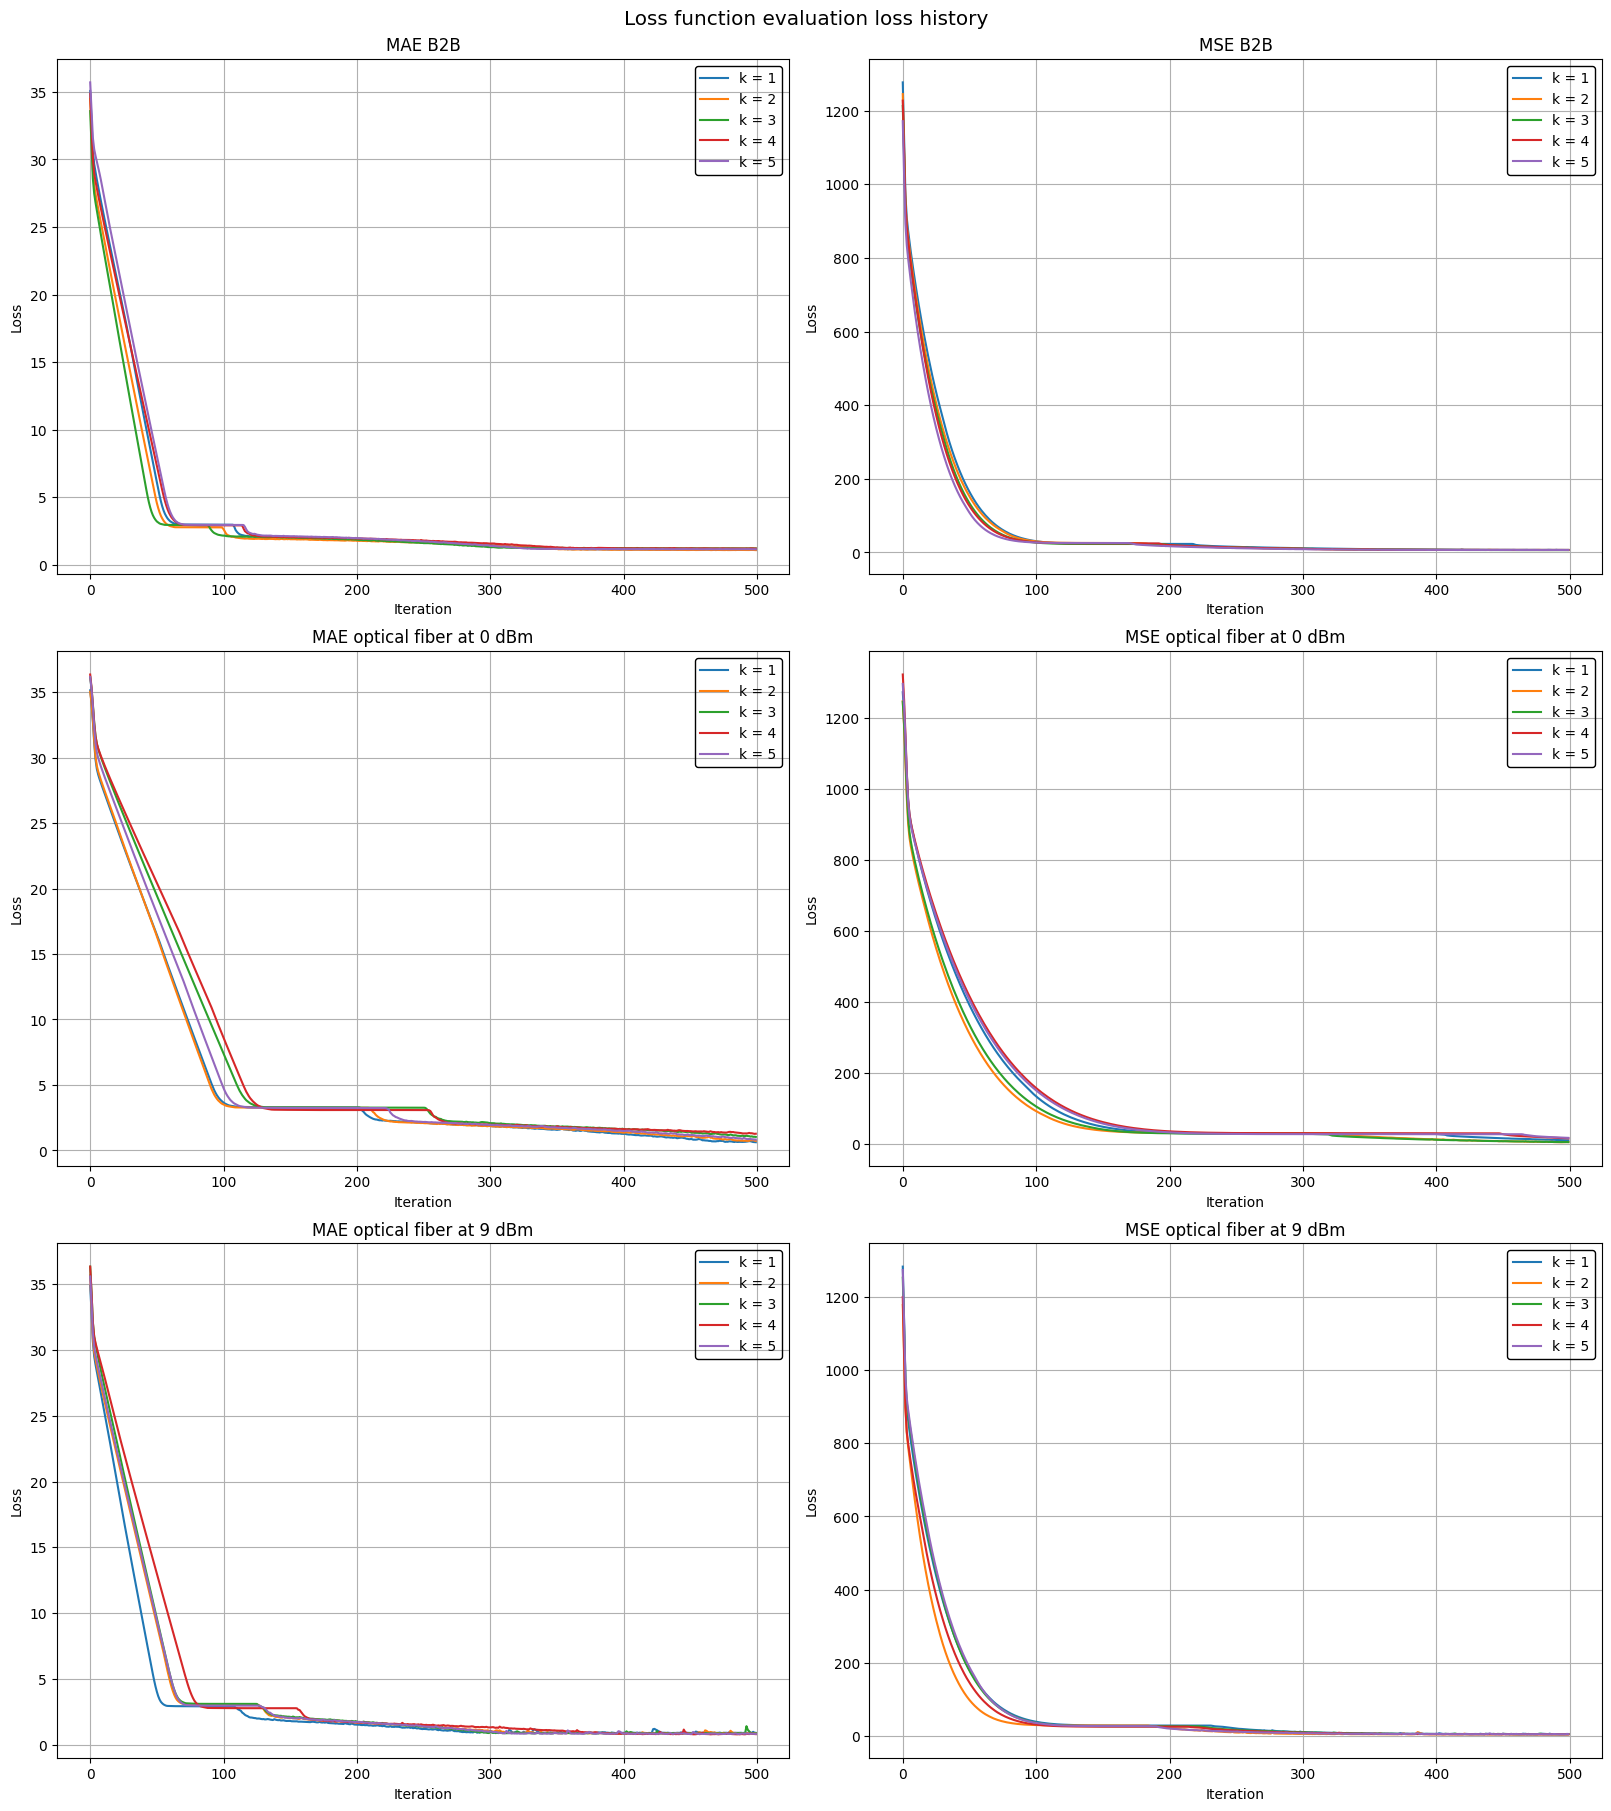

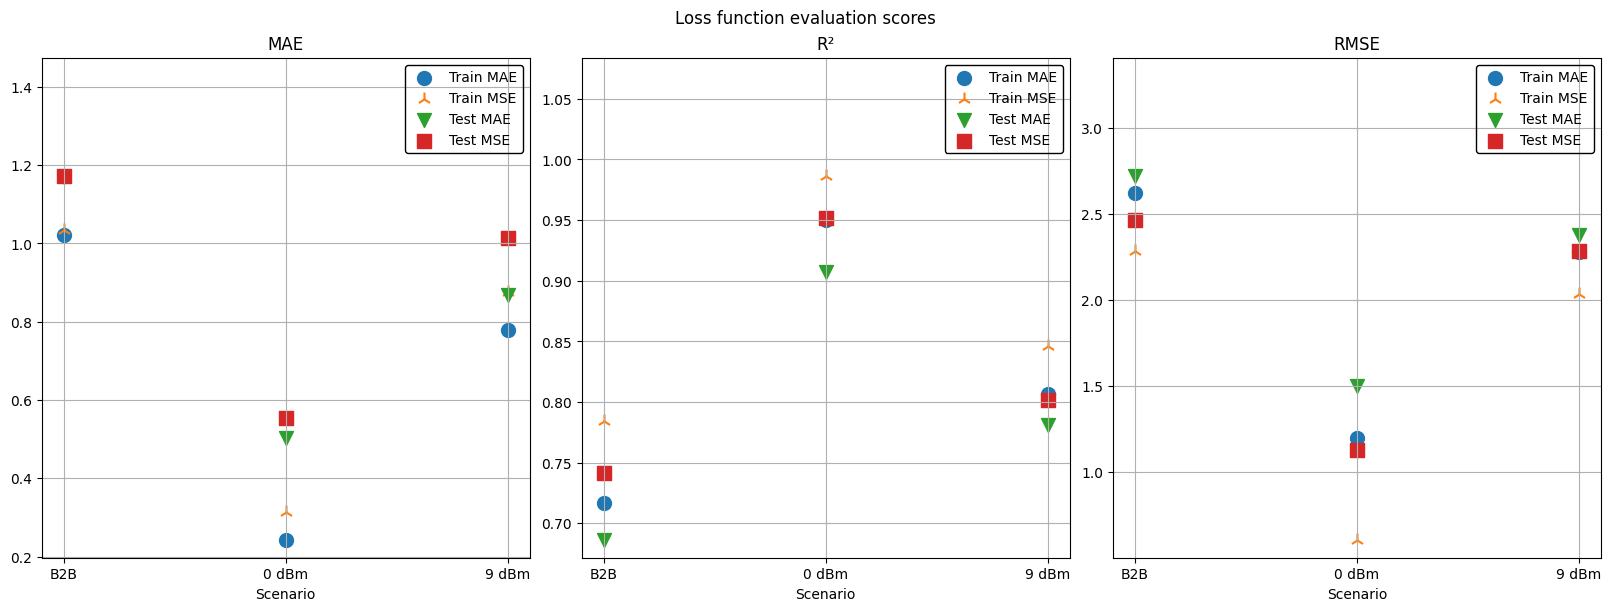

In [90]:
scores = [scores_FCM_MAE_B2B, scores_FCM_MSE_B2B, scores_FCM_MAE_fiber0, scores_FCM_MSE_fiber0, scores_FCM_MAE_fiber9, scores_FCM_MSE_fiber9]
plot_loss_scores(scores, "Loss function evaluation")

# Clasificador

## 2 clases

### FCM

In [17]:
interval_lst = [(0, 35), (35, 50)]
df_2classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_2classes_FCM_B2B = df_2classes_FCM[0:987, :]
# 0dBm optical fiber
df_2classes_FCM_fiber0 = df_2classes_FCM[988:1520, :]
# 9dBm optical fiber
df_2classes_FCM_fiber9 = df_2classes_FCM[1521:, :]

#### B2B

In [18]:
args = {"data": df_2classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_B2B = calc_once("scores_2classes_FCM_B2B", test_classification_model, args)

#### Fibra óptica a 0dBm

In [19]:
args = {"data": df_2classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_fiber0 = calc_once("scores_2classes_FCM_fiber0", test_classification_model, args)

#### Fibra óptica a 9dBm

In [20]:
args = {"data": df_2classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_FCM_fiber9 = calc_once("scores_2classes_FCM_fiber9", test_classification_model, args)

### GKM

In [21]:
interval_lst = [(0, 35), (35, 50)]
df_2classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_2classes_GKM_B2B = df_2classes_GKM[0:987, :]
# 0dBm optical fiber
df_2classes_GKM_fiber0 = df_2classes_GKM[988:1520, :]
# 9dBm optical fiber
df_2classes_GKM_fiber9 = df_2classes_GKM[1521:, :]

#### B2B

In [22]:
args = {"data": df_2classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_GKM_B2B = calc_once("scores_2classes_GKM_B2B", test_classification_model, args)

#### Fibra óptica a 0dBm

In [23]:
args = {"data": df_2classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_GKM_fiber0 = calc_once("scores_2classes_GKM_fiber0", test_classification_model, args)

#### Fibra óptica a 9dBm

In [24]:
args = {"data": df_2classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_2classes_GKM_fiber9 = calc_once("scores_2classes_GKM_fiber9", test_classification_model, args)

In [25]:
%store scores_2classes_FCM_B2B
%store scores_2classes_GKM_B2B
%store scores_2classes_FCM_fiber0
%store scores_2classes_GKM_fiber0
%store scores_2classes_FCM_fiber9
%store scores_2classes_GKM_fiber9

Stored 'scores_2classes_FCM_B2B' (dict)
Stored 'scores_2classes_GKM_B2B' (dict)
Stored 'scores_2classes_FCM_fiber0' (dict)
Stored 'scores_2classes_GKM_fiber0' (dict)
Stored 'scores_2classes_FCM_fiber9' (dict)
Stored 'scores_2classes_GKM_fiber9' (dict)


### Gráficas

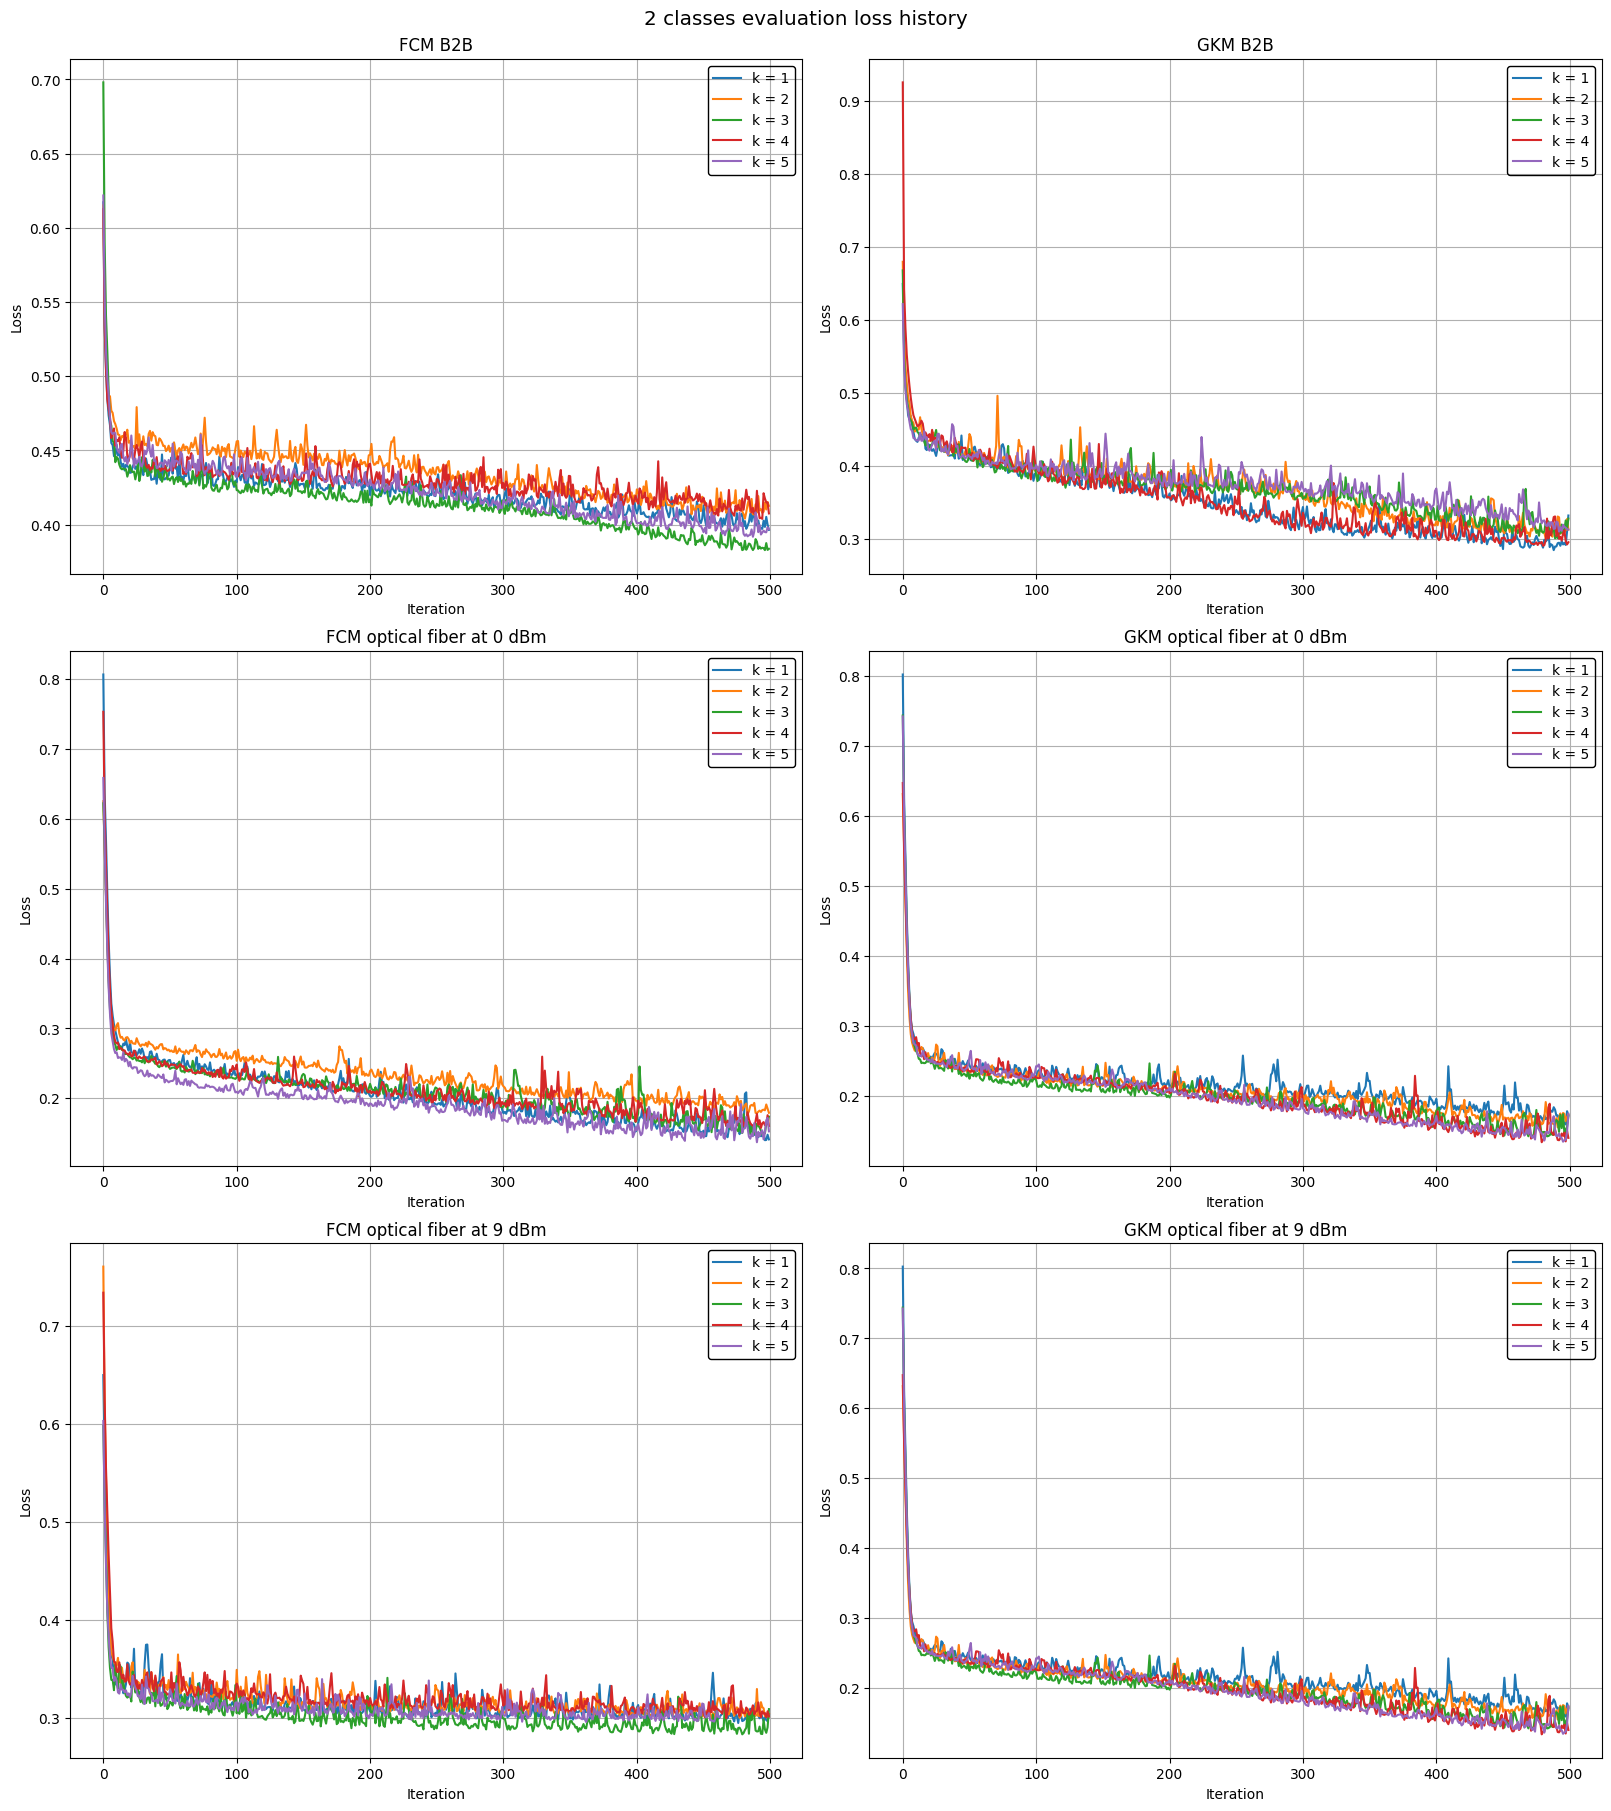

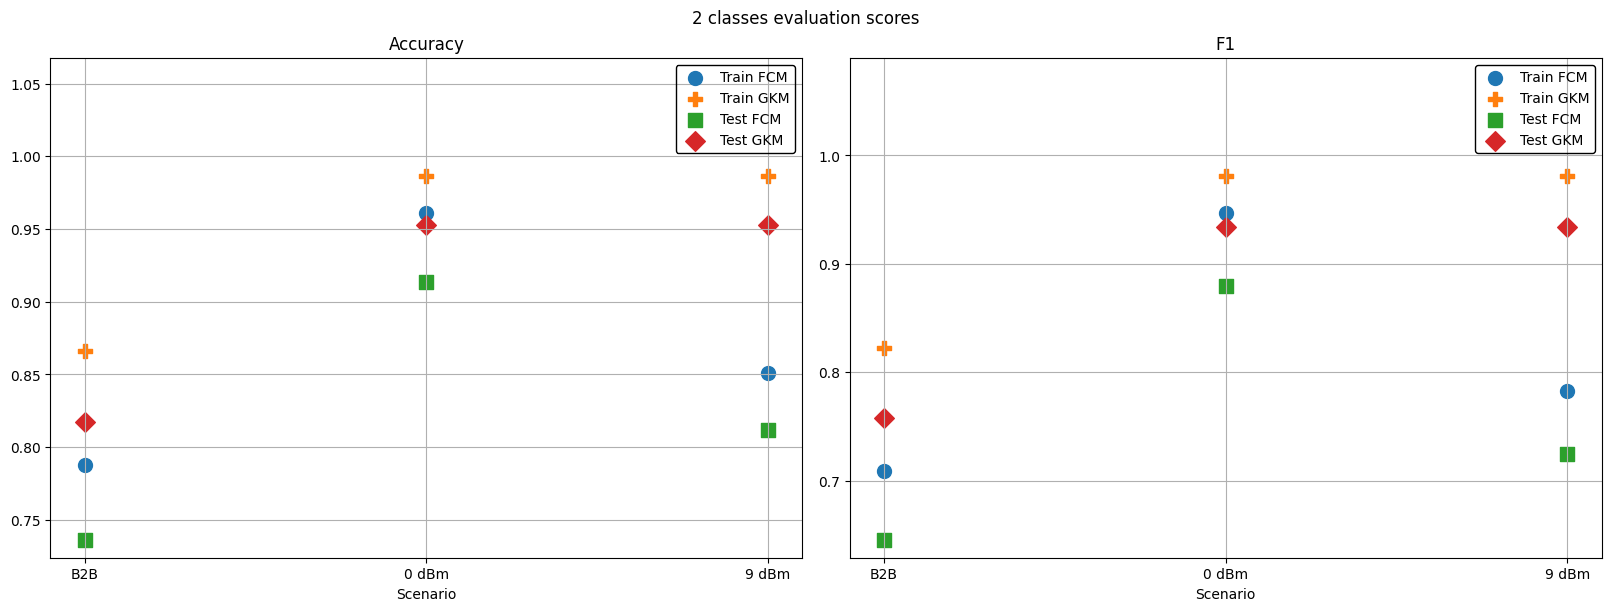

In [26]:
scores = [scores_2classes_FCM_B2B, scores_2classes_GKM_B2B, scores_2classes_FCM_fiber0, scores_2classes_GKM_fiber0, scores_2classes_FCM_fiber9, scores_2classes_GKM_fiber0]
plot_classes_scores(scores, "2 classes evaluation")

## 3 clases

### FCM

In [27]:
interval_lst = [(0, 32), (32, 35), (35, 50)]
df_3classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_3classes_FCM_B2B = df_3classes_FCM[0:987, :]
# 0dBm optical fiber
df_3classes_FCM_fiber0 = df_3classes_FCM[988:1520, :]
# 9dBm optical fiber
df_3classes_FCM_fiber9 = df_3classes_FCM[1521:, :]

#### B2B

In [28]:
args = {"data": df_3classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_FCM_B2B = calc_once("scores_3classes_FCM_B2B", test_classification_model, args)

#### Fibra óptica a 0dBm

In [29]:
args = {"data": df_3classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_FCM_fiber0 = calc_once("scores_3classes_FCM_fiber0", test_classification_model, args)

#### Fibra óptica a 9dBm

In [30]:
args = {"data": df_3classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_FCM_fiber9 = calc_once("scores_3classes_FCM_fiber9", test_classification_model, args)

### GKM

In [31]:
interval_lst = [(0, 32), (32, 35), (35, 50)]
df_3classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_3classes_GKM_B2B = df_3classes_GKM[0:987, :]
# 0dBm optical fiber
df_3classes_GKM_fiber0 = df_3classes_GKM[988:1520, :]
# 9dBm optical fiber
df_3classes_GKM_fiber9 = df_3classes_GKM[1521:, :]

#### B2B

In [32]:
args = {"data": df_3classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_GKM_B2B = calc_once("scores_3classes_GKM_B2B", test_classification_model, args)

#### Fibra óptica a 0dBm

In [33]:
args = {"data": df_3classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_GKM_fiber0 = calc_once("scores_3classes_GKM_fiber0", test_classification_model, args)

#### Fibra óptica a 9dBm

In [34]:
args = {"data": df_3classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_3classes_GKM_fiber9 = calc_once("scores_3classes_GKM_fiber9", test_classification_model, args)

In [35]:
%store scores_3classes_FCM_B2B
%store scores_3classes_GKM_B2B
%store scores_3classes_FCM_fiber0
%store scores_3classes_GKM_fiber0
%store scores_3classes_FCM_fiber9
%store scores_3classes_GKM_fiber9

Stored 'scores_3classes_FCM_B2B' (dict)
Stored 'scores_3classes_GKM_B2B' (dict)
Stored 'scores_3classes_FCM_fiber0' (dict)
Stored 'scores_3classes_GKM_fiber0' (dict)
Stored 'scores_3classes_FCM_fiber9' (dict)
Stored 'scores_3classes_GKM_fiber9' (dict)


### Gráficas

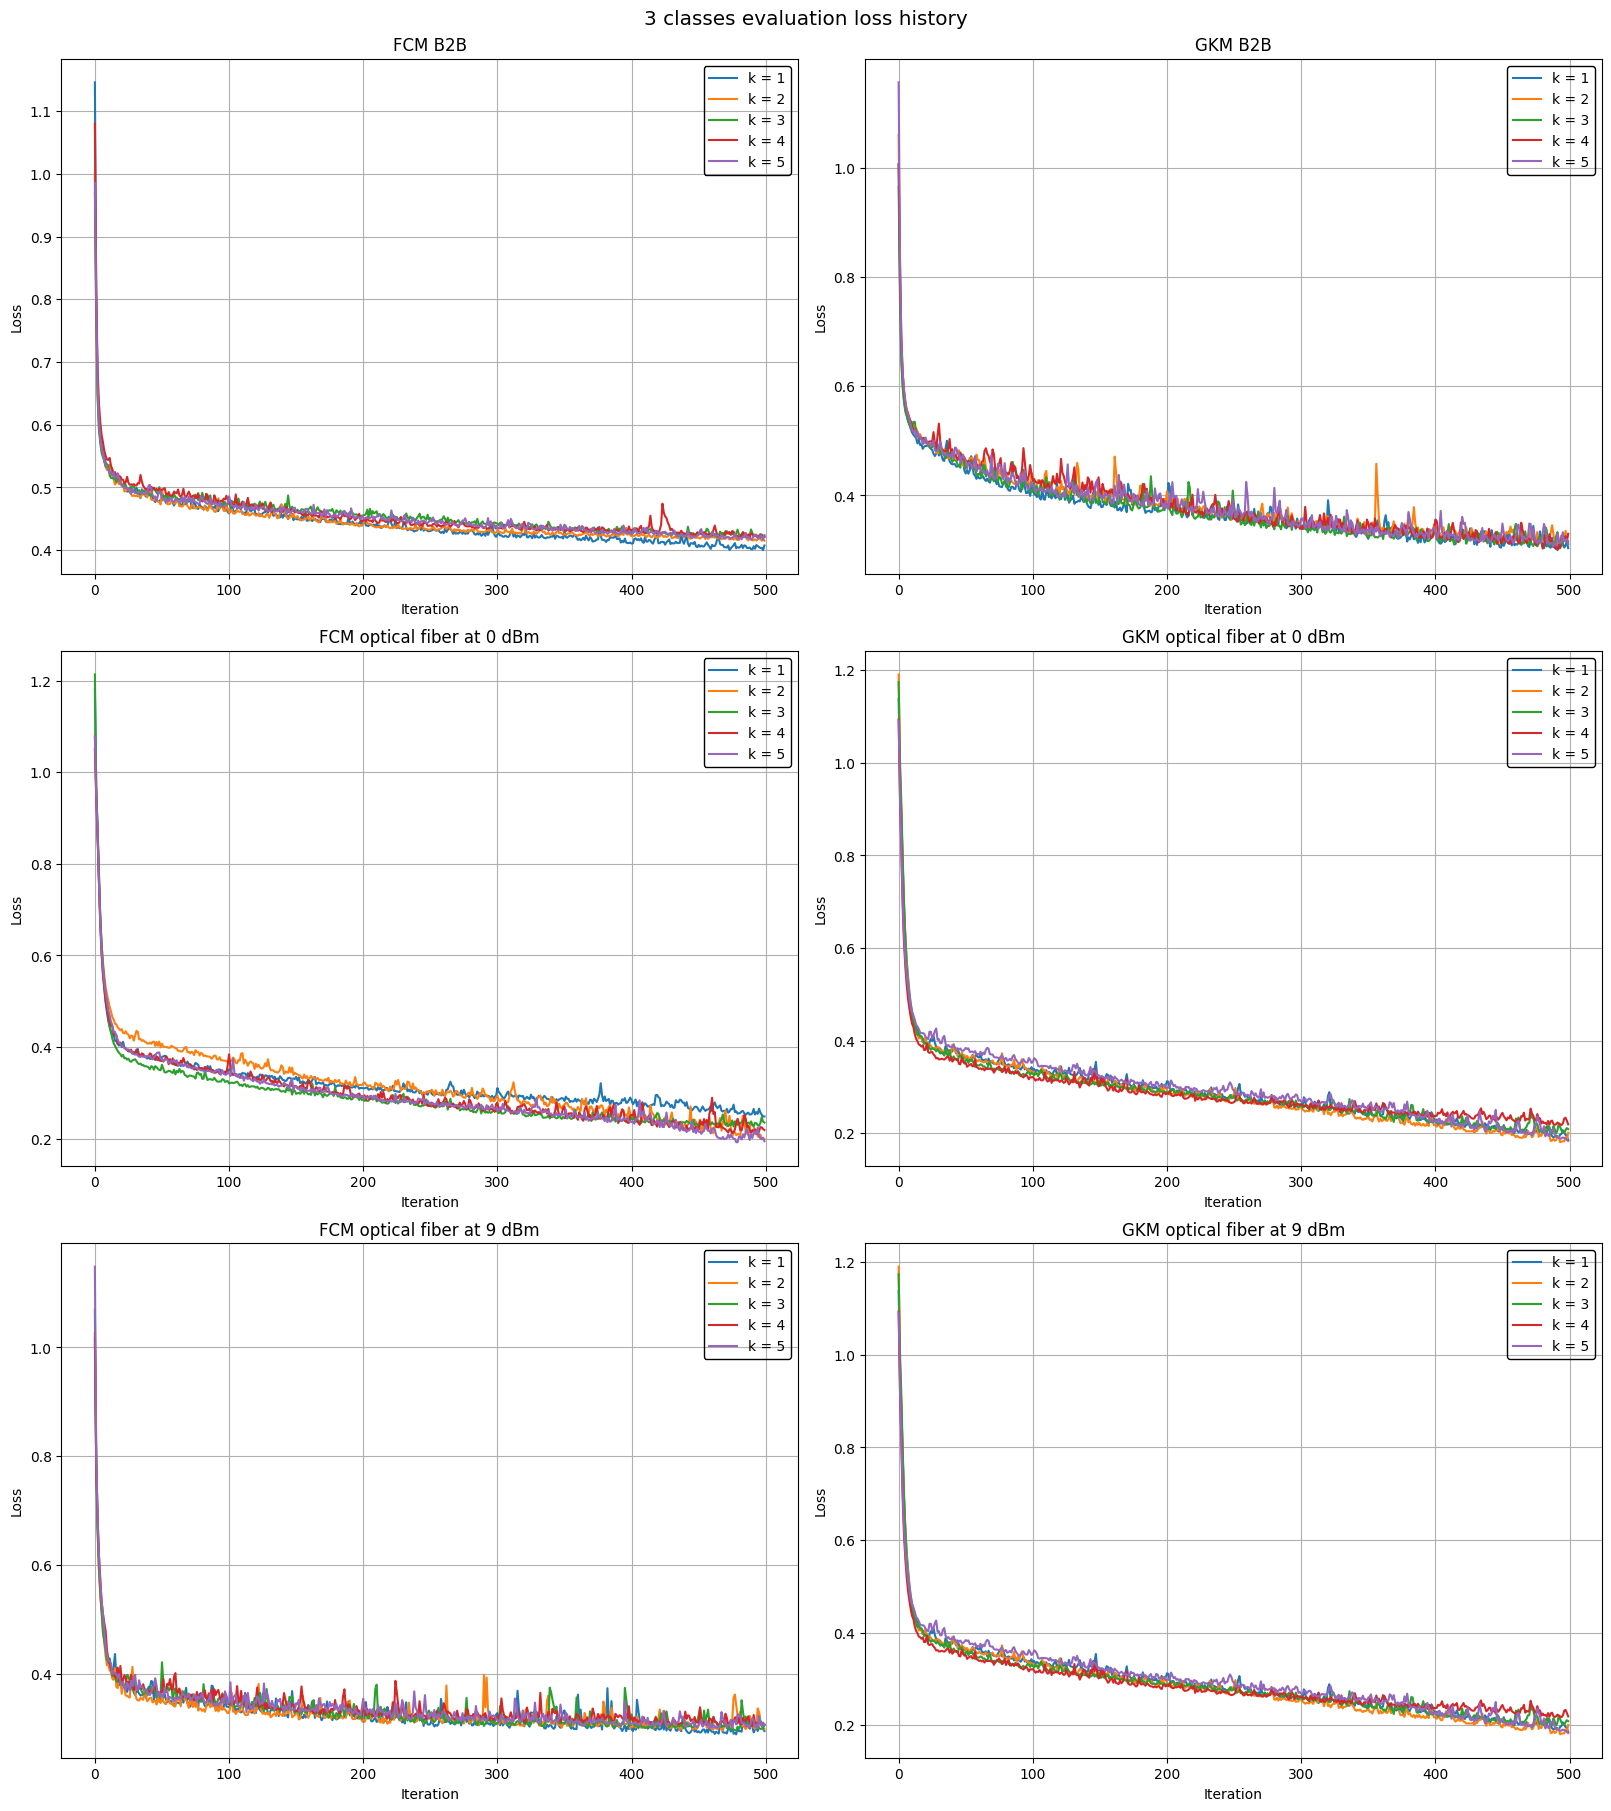

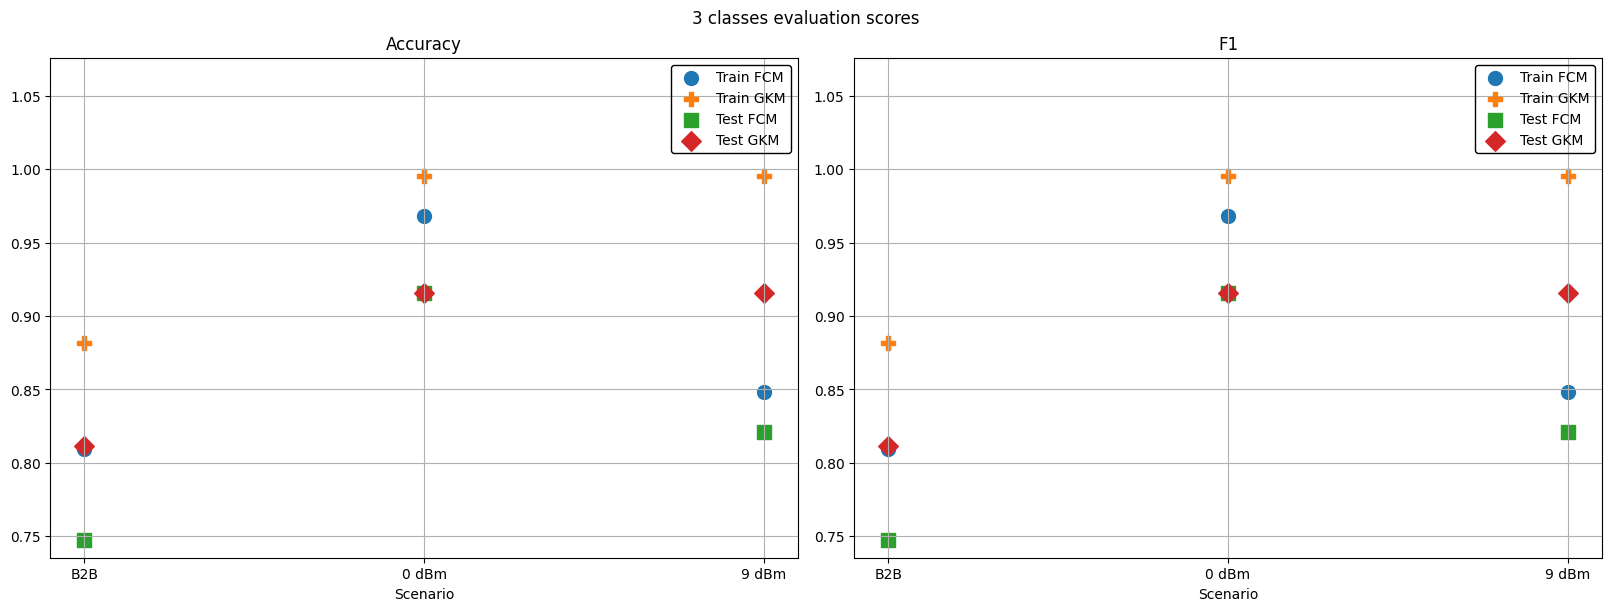

In [36]:
scores = [scores_3classes_FCM_B2B, scores_3classes_GKM_B2B, scores_3classes_FCM_fiber0, scores_3classes_GKM_fiber0, scores_3classes_FCM_fiber9, scores_3classes_GKM_fiber0]
plot_classes_scores(scores, "3 classes evaluation")

## 4 clases

### FCM

In [37]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 50)]
df_4classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_4classes_FCM_B2B = df_4classes_FCM[0:987, :]
# 0dBm optical fiber
df_4classes_FCM_fiber0 = df_4classes_FCM[988:1520, :]
# 9dBm optical fiber
df_4classes_FCM_fiber9 = df_4classes_FCM[1521:, :]

#### B2B

In [38]:
args = {"data": df_4classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_FCM_B2B = calc_once("scores_4classes_FCM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2064
7/7 [==============================] - 0s 2ms/step
Needed iterations: 2220
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2122
7/7 [==============================] - 0s 1ms/step
Needed iterations: 1766
7/7 [==============================] - 0s 885us/step
Needed iterations: 1762
7/7 [==============================] - 0s 900us/step
Time elapsed: 2.19 minutes


#### Fibra óptica a 0dBm

In [39]:
args = {"data": df_4classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_FCM_fiber0 = calc_once("scores_4classes_FCM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2458
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2489
4/4 [==============================] - 0s 932us/step
Needed iterations: 2283
4/4 [==============================] - 0s 2ms/step
Needed iterations: 1993
4/4 [==============================] - 0s 913us/step
Needed iterations: 2517
4/4 [==============================] - 0s 1ms/step
Time elapsed: 1.55 minutes


#### Fibra óptica a 9dBm

In [40]:
args = {"data": df_4classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_FCM_fiber9 = calc_once("scores_4classes_FCM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2197
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1592
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1786
6/6 [==============================] - 0s 905us/step
Needed iterations: 2222
6/6 [==============================] - 0s 1ms/step
Needed iterations: 1244
6/6 [==============================] - 0s 875us/step
Time elapsed: 1.99 minutes


### GKM

In [41]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 50)]
df_4classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_4classes_GKM_B2B = df_4classes_GKM[0:987, :]
# 0dBm optical fiber
df_4classes_GKM_fiber0 = df_4classes_GKM[988:1520, :]
# 9dBm optical fiber
df_4classes_GKM_fiber9 = df_4classes_GKM[1521:, :]

#### B2B

In [42]:
args = {"data": df_4classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_GKM_B2B = calc_once("scores_4classes_GKM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2458
7/7 [==============================] - 0s 810us/step
Needed iterations: 2548
7/7 [==============================] - 0s 772us/step
Needed iterations: 3848
7/7 [==============================] - 0s 870us/step
Needed iterations: 3063
7/7 [==============================] - 0s 3ms/step
Needed iterations: 2884
7/7 [==============================] - 0s 828us/step
Time elapsed: 3.29 minutes


#### Fibra óptica a 0dBm

In [43]:
args = {"data": df_4classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_GKM_fiber0 = calc_once("scores_4classes_GKM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2658
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2999
4/4 [==============================] - 0s 973us/step
Needed iterations: 2218
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2677
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2845
4/4 [==============================] - 0s 1ms/step
Time elapsed: 1.71 minutes


#### Fibra óptica a 9dBm

In [44]:
args = {"data": df_4classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_4classes_GKM_fiber9 = calc_once("scores_4classes_GKM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2338
6/6 [==============================] - 0s 834us/step
Needed iterations: 1234
6/6 [==============================] - 0s 847us/step
Needed iterations: 1412
6/6 [==============================] - 0s 827us/step
Needed iterations: 1068
6/6 [==============================] - 0s 831us/step
Needed iterations: 1831
6/6 [==============================] - 0s 1ms/step
Time elapsed: 1.72 minutes


In [45]:
%store scores_4classes_FCM_B2B
%store scores_4classes_GKM_B2B
%store scores_4classes_FCM_fiber0
%store scores_4classes_GKM_fiber0
%store scores_4classes_FCM_fiber9
%store scores_4classes_GKM_fiber9

Stored 'scores_4classes_FCM_B2B' (dict)
Stored 'scores_4classes_GKM_B2B' (dict)
Stored 'scores_4classes_FCM_fiber0' (dict)
Stored 'scores_4classes_GKM_fiber0' (dict)
Stored 'scores_4classes_FCM_fiber9' (dict)
Stored 'scores_4classes_GKM_fiber9' (dict)


### Gráficas

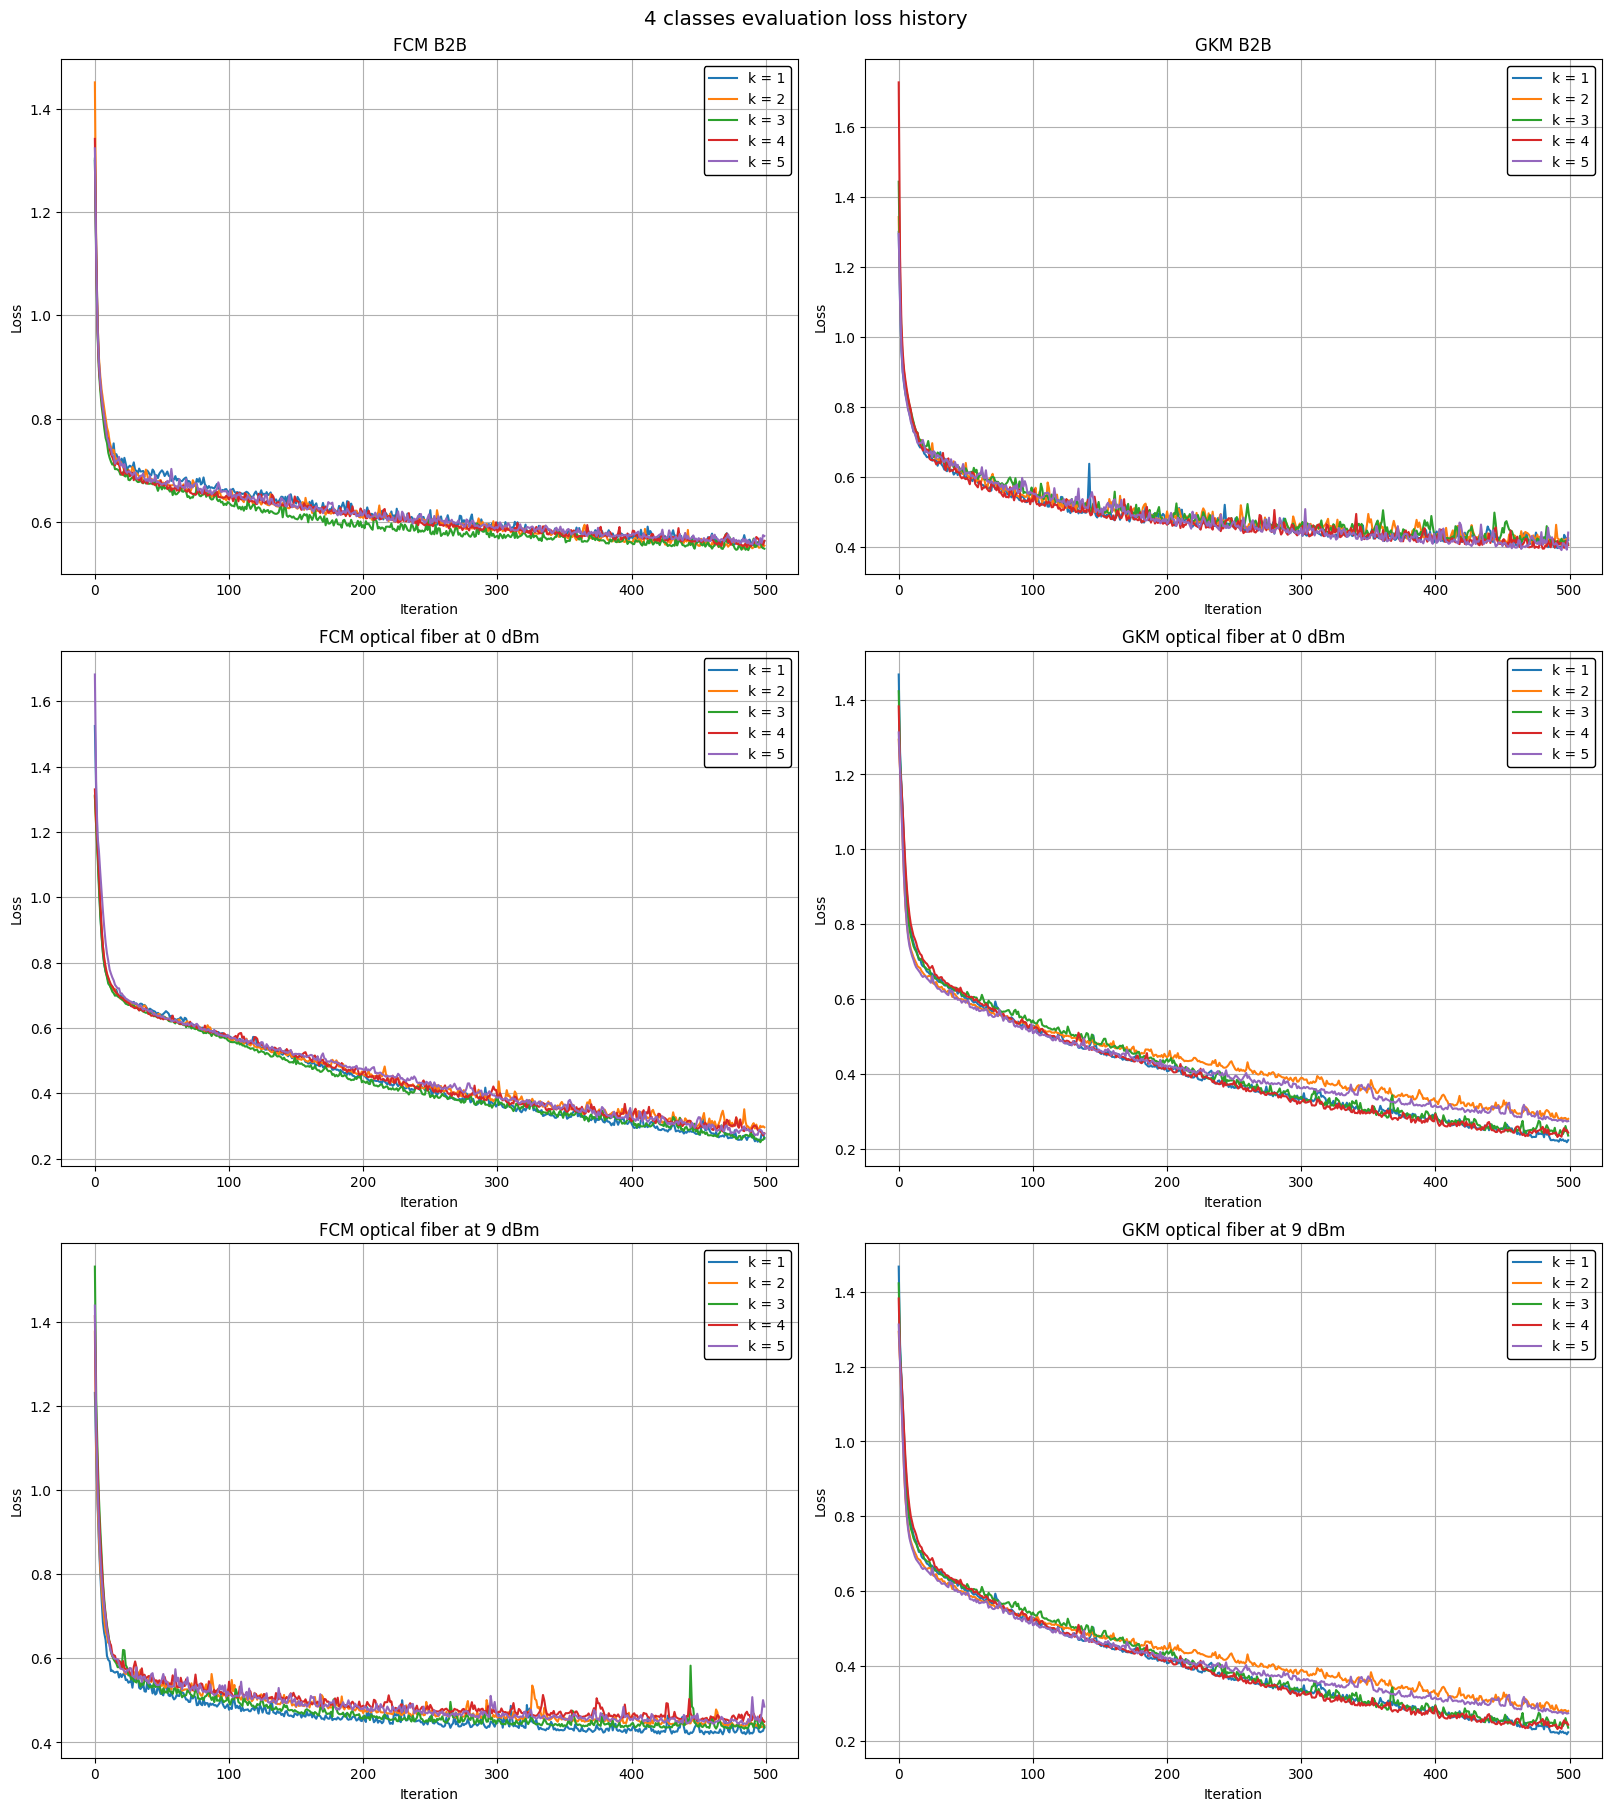

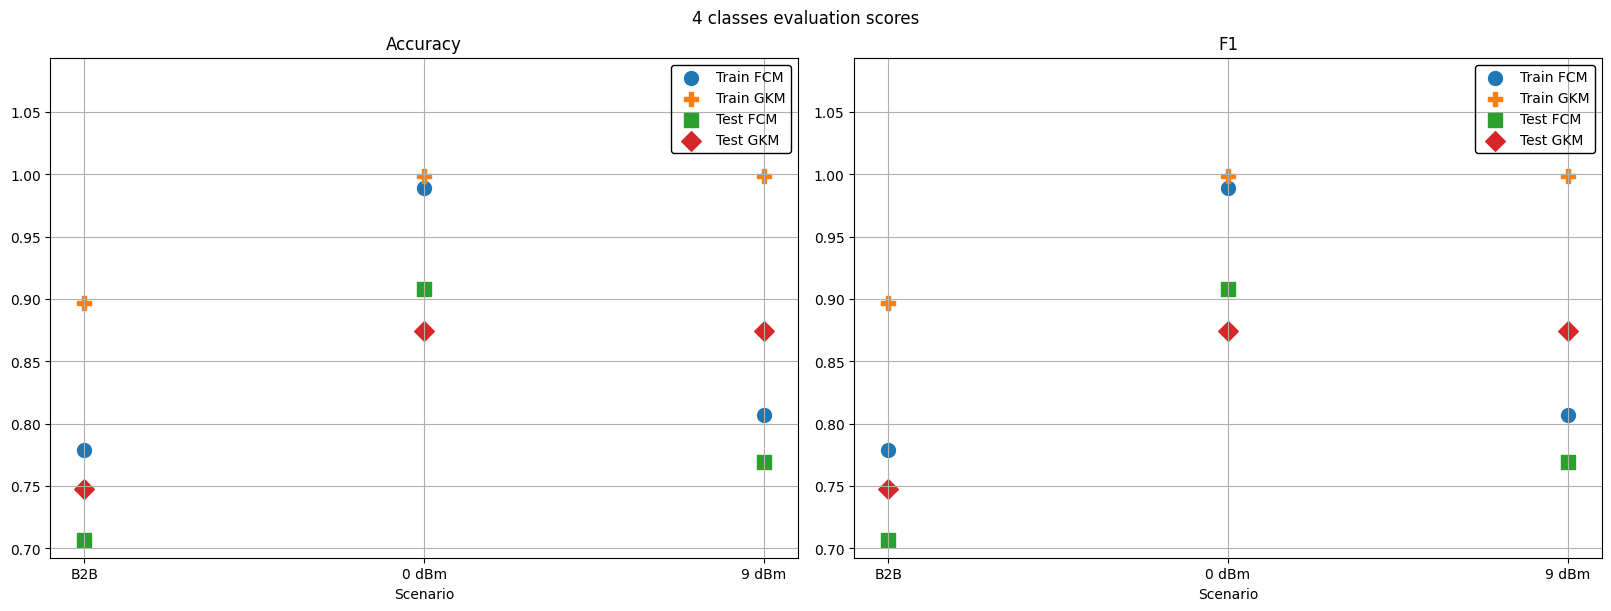

In [46]:
scores = [scores_4classes_FCM_B2B, scores_4classes_GKM_B2B, scores_4classes_FCM_fiber0, scores_4classes_GKM_fiber0, scores_4classes_FCM_fiber9, scores_4classes_GKM_fiber0]
plot_classes_scores(scores, "4 classes evaluation")

## 5 clases

### FCM

In [47]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 37.5), (37.5, 50)]
df_5classes_FCM = classificator(df_FCM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_5classes_FCM_B2B = df_5classes_FCM[0:987, :]
# 0dBm optical fiber
df_5classes_FCM_fiber0 = df_5classes_FCM[988:1520, :]
# 9dBm optical fiber
df_5classes_FCM_fiber9 = df_5classes_FCM[1521:, :]

#### B2B

In [48]:
args = {"data": df_5classes_FCM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_FCM_B2B = calc_once("scores_5classes_FCM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2895
7/7 [==============================] - 0s 886us/step
Needed iterations: 2964
7/7 [==============================] - 0s 911us/step
Needed iterations: 2804
7/7 [==============================] - 0s 1ms/step
Needed iterations: 1957
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2854
7/7 [==============================] - 0s 2ms/step
Time elapsed: 3.20 minutes


#### Fibra óptica a 0dBm

In [49]:
args = {"data": df_5classes_FCM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_FCM_fiber0 = calc_once("scores_5classes_FCM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2735
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2593
4/4 [==============================] - 0s 1ms/step
Needed iterations: 1350
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2463
4/4 [==============================] - 0s 953us/step
Needed iterations: 1514
4/4 [==============================] - 0s 900us/step
Time elapsed: 1.52 minutes


#### Fibra óptica a 9dBm

In [50]:
args = {"data": df_5classes_FCM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_FCM_fiber9 = calc_once("scores_5classes_FCM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 1141
6/6 [==============================] - 0s 880us/step
Needed iterations: 2109
6/6 [==============================] - 0s 788us/step
Needed iterations: 1005
6/6 [==============================] - 0s 964us/step
Needed iterations: 1656
6/6 [==============================] - 0s 790us/step
Needed iterations: 1568
6/6 [==============================] - 0s 1ms/step
Time elapsed: 1.42 minutes


### GKM

In [51]:
interval_lst = [(0, 31.5), (31.5, 33.5), (33.5, 35), (35, 37.5), (37.5, 50)]
df_5classes_GKM = classificator(df_GKM, interval_lst, "column_20")

# Scenarios split
# Back-to-back (B2B)
df_5classes_GKM_B2B = df_5classes_GKM[0:987, :]
# 0dBm optical fiber
df_5classes_GKM_fiber0 = df_5classes_GKM[988:1520, :]
# 9dBm optical fiber
df_5classes_GKM_fiber9 = df_5classes_GKM[1521:, :]

#### B2B

In [52]:
args = {"data": df_5classes_GKM_B2B, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_GKM_B2B = calc_once("scores_5classes_GKM_B2B", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 2234
7/7 [==============================] - 0s 1ms/step
Needed iterations: 2160
7/7 [==============================] - 0s 773us/step
Needed iterations: 3462
7/7 [==============================] - 0s 8ms/step
Needed iterations: 1842
7/7 [==============================] - 0s 892us/step
Needed iterations: 3513
7/7 [==============================] - 0s 987us/step
Time elapsed: 3.36 minutes


#### Fibra óptica a 0dBm

In [53]:
args = {"data": df_5classes_GKM_fiber0, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_GKM_fiber0 = calc_once("scores_5classes_GKM_fiber0", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 3789
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2887
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2948
4/4 [==============================] - 0s 1ms/step
Needed iterations: 3178
4/4 [==============================] - 0s 1ms/step
Needed iterations: 2765
4/4 [==============================] - 0s 990us/step
Time elapsed: 2.02 minutes


#### Fibra óptica a 9dBm

In [54]:
args = {"data": df_5classes_GKM_fiber9, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy"}
scores_5classes_GKM_fiber9 = calc_once("scores_5classes_GKM_fiber9", test_classification_model, args)

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 1963
6/6 [==============================] - 0s 819us/step
Needed iterations: 1874
6/6 [==============================] - 0s 840us/step
Needed iterations: 1028
6/6 [==============================] - 0s 954us/step
Needed iterations: 2161
6/6 [==============================] - 0s 944us/step
Needed iterations: 3006
6/6 [==============================] - 0s 1ms/step
Time elapsed: 2.02 minutes


In [55]:
%store scores_5classes_FCM_B2B
%store scores_5classes_GKM_B2B
%store scores_5classes_FCM_fiber0
%store scores_5classes_GKM_fiber0
%store scores_5classes_FCM_fiber9
%store scores_5classes_GKM_fiber9

Stored 'scores_5classes_FCM_B2B' (dict)
Stored 'scores_5classes_GKM_B2B' (dict)
Stored 'scores_5classes_FCM_fiber0' (dict)
Stored 'scores_5classes_GKM_fiber0' (dict)
Stored 'scores_5classes_FCM_fiber9' (dict)
Stored 'scores_5classes_GKM_fiber9' (dict)


### Gráficas

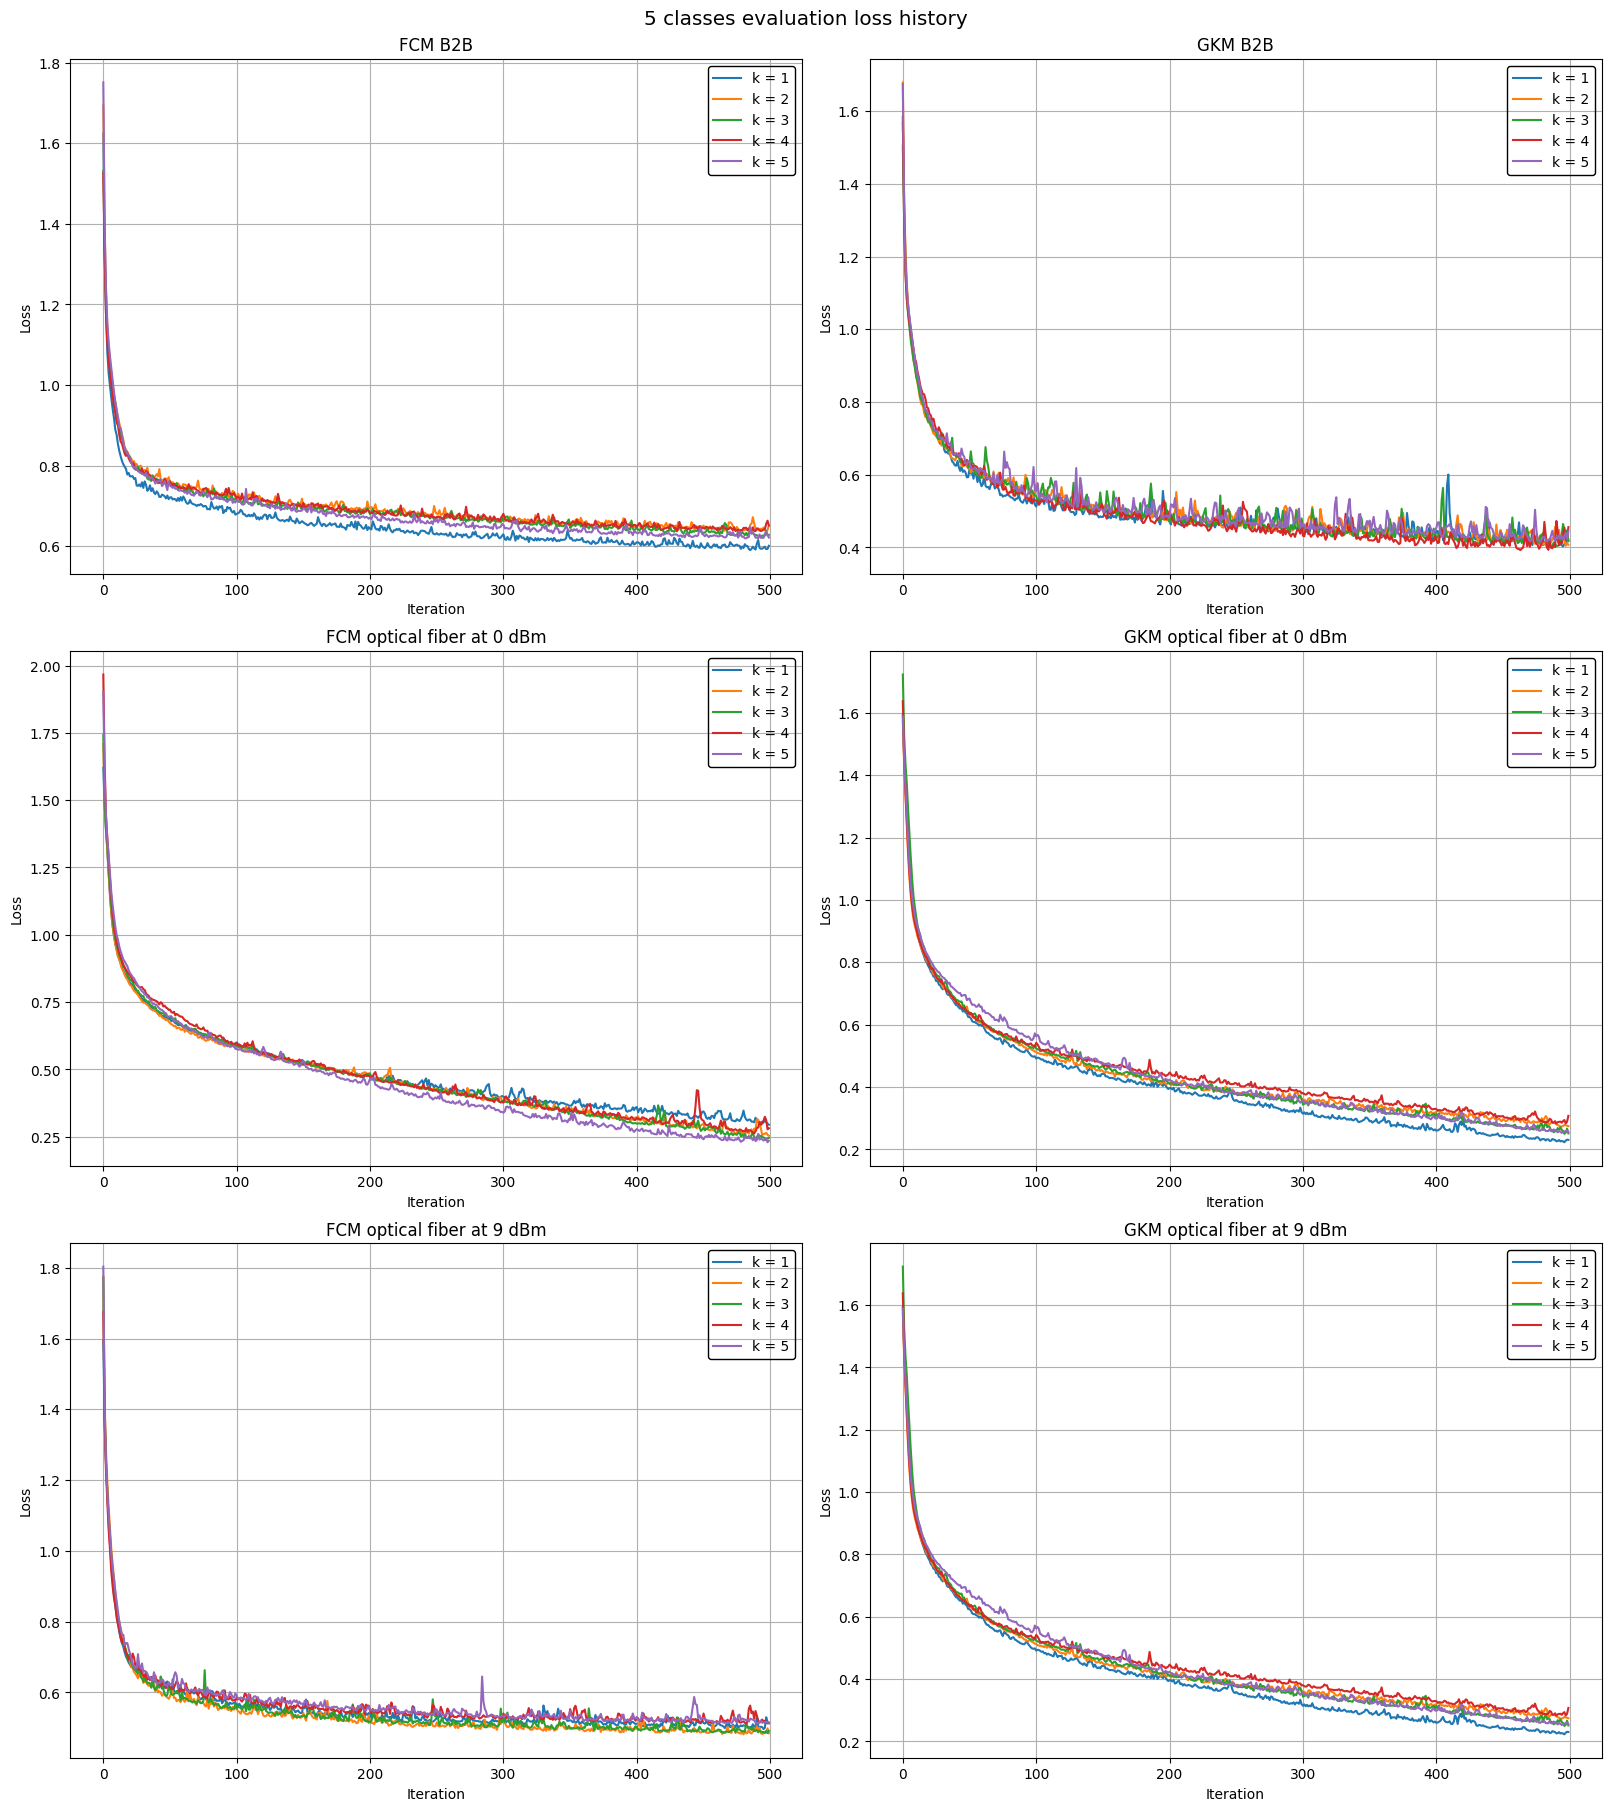

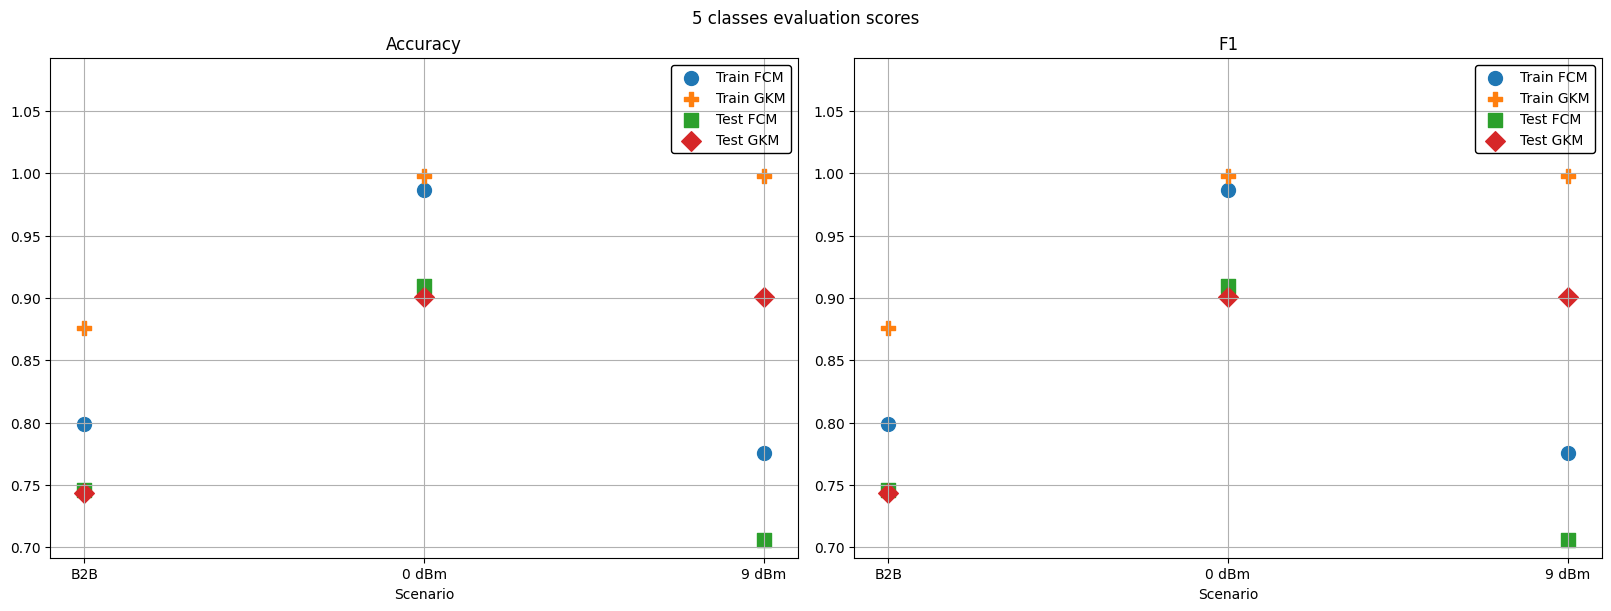

In [56]:
scores = [scores_5classes_FCM_B2B, scores_5classes_GKM_B2B, scores_5classes_FCM_fiber0, scores_5classes_GKM_fiber0, scores_5classes_FCM_fiber9, scores_5classes_GKM_fiber0]
plot_classes_scores(scores, "5 classes evaluation")

In [88]:
scores = [scores_2classes_FCM_B2B, scores_3classes_FCM_B2B, scores_4classes_FCM_B2B, scores_5classes_FCM_B2B]
scores_classes_FCM_B2B = [float(np.average(score_classes_FCM_B2B.get("acc").get("test"))) for score_classes_FCM_B2B in scores]

scores = [scores_2classes_FCM_fiber0, scores_3classes_FCM_fiber0, scores_4classes_FCM_fiber0, scores_5classes_FCM_fiber0]
scores_classes_FCM_fiber0 = [float(np.average(score_classes_FCM_fiber0.get("acc").get("test"))) for score_classes_FCM_fiber0 in scores]

scores = [scores_2classes_FCM_fiber9, scores_3classes_FCM_fiber9, scores_4classes_FCM_fiber9, scores_5classes_FCM_fiber9]
scores_classes_FCM_fiber9 = [float(np.average(score_classes_FCM_fiber9.get("acc").get("test"))) for score_classes_FCM_fiber9 in scores]

classifier_FCM_df = pl.DataFrame(
        {"Classes": range(2, 6), "B2B": scores_classes_FCM_B2B, "Fiber @ 0dBm": scores_classes_FCM_fiber0, "Fiber @ 9dBm": scores_classes_FCM_fiber9}
    )

classifier_FCM_df

shape: (4, 4)
┌─────────┬──────────┬──────────────┬──────────────┐
│ Classes ┆ B2B      ┆ Fiber @ 0dBm ┆ Fiber @ 9dBm │
│ ---     ┆ ---      ┆ ---          ┆ ---          │
│ i64     ┆ f64      ┆ f64          ┆ f64          │
╞═════════╪══════════╪══════════════╪══════════════╡
│ 2       ┆ 0.736507 ┆ 0.913543     ┆ 0.811928     │
│ 3       ┆ 0.747798 ┆ 0.915376     ┆ 0.82098      │
│ 4       ┆ 0.707168 ┆ 0.907865     ┆ 0.769187     │
│ 5       ┆ 0.745737 ┆ 0.909716     ┆ 0.706151     │
└─────────┴──────────┴──────────────┴──────────────┘

In [87]:
scores = [scores_2classes_GKM_B2B, scores_3classes_GKM_B2B, scores_4classes_GKM_B2B, scores_5classes_GKM_B2B]
scores_classes_GKM_B2B = [float(np.average(score_classes_GKM_B2B.get("acc").get("test"))) for score_classes_GKM_B2B in scores]

scores = [scores_2classes_GKM_fiber0, scores_3classes_GKM_fiber0, scores_4classes_GKM_fiber0, scores_5classes_GKM_fiber0]
scores_classes_GKM_fiber0 = [float(np.average(score_classes_GKM_fiber0.get("acc").get("test"))) for score_classes_GKM_fiber0 in scores]

scores = [scores_2classes_GKM_fiber9, scores_3classes_GKM_fiber9, scores_4classes_GKM_fiber9, scores_5classes_GKM_fiber9]
scores_classes_GKM_fiber9 = [float(np.average(score_classes_GKM_fiber9.get("acc").get("test"))) for score_classes_GKM_fiber9 in scores]

classifier_GKM_df = pl.DataFrame(
        {"Classes": range(2, 6), "B2B": scores_classes_GKM_B2B, "Fiber @ 0dBm": scores_classes_GKM_fiber0, "Fiber @ 9dBm": scores_classes_GKM_fiber9}
    )

classifier_GKM_df

shape: (4, 4)
┌─────────┬──────────┬──────────────┬──────────────┐
│ Classes ┆ B2B      ┆ Fiber @ 0dBm ┆ Fiber @ 9dBm │
│ ---     ┆ ---      ┆ ---          ┆ ---          │
│ i64     ┆ f64      ┆ f64          ┆ f64          │
╞═════════╪══════════╪══════════════╪══════════════╡
│ 2       ┆ 0.817597 ┆ 0.953007     ┆ 0.888485     │
│ 3       ┆ 0.811552 ┆ 0.915412     ┆ 0.884022     │
│ 4       ┆ 0.747711 ┆ 0.874008     ┆ 0.823208     │
│ 5       ┆ 0.743665 ┆ 0.900406     ┆ 0.811947     │
└─────────┴──────────┴──────────────┴──────────────┘